## Install this

In [3]:
# Install the latest version of author's repo neural ode implementation
!git clone https://github.com/rtqichen/torchdiffeq.git
!cd torchdiffeq && pip install -e .
!ls torchdiffeq/torchdiffeq

fatal: destination path 'torchdiffeq' already exists and is not an empty directory.
Obtaining file:///content/torchdiffeq
  Attempting uninstall: torchdiffeq
    Found existing installation: torchdiffeq 0.2.2
    Can't uninstall 'torchdiffeq'. No files were found to uninstall.
  Running setup.py develop for torchdiffeq
_impl  __init__.py  __pycache__


## m1m2m3m4m5m6m7 as input and m1m2m3m4m5m6m7m8m9m10 as output for training.

### Apple : Trial 1

In [ ]:
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd 
from pandas import concat
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
from torchdiffeq.torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dict_tickers = {
    'Apple': 'AAPL',
    'Microsoft': 'MSFT',
    'Google': 'GOOG',
    'Bitcoin': 'BTC-USD',
    'Facebook': 'FB',
    'Walmart': 'WMT',
    'Amazon': 'AMZN',
    'CVS': 'CVS',
    'Berkshire': 'BRK-B',
    'ExxonMobil': 'XOM',
    'AtandT': 'T',
    'Costco': 'COST',
    'Walgreens': 'WBA',
    'Kroger': 'KR',
    'JPMorgan': 'JPM',
    'Verizon': 'VZ',
    'FordMotor': 'F',
    'GeneralMotors': 'GM',
    'Dell': 'DELL',
    'BankOfAmerica': 'BAC',
    'Target': 'TGT',
    'GeneralElectric': 'GE',
    'JohnsonandJohnson': 'JNJ',
    'Nvidia': 'NVDA',
    'Intel': 'INTC',
}


def stockDataTransformer(filepath):
    df = pd.read_csv(filepath)
    df.set_index('Date', inplace=True)
    df1 = df[['Open', 'Close']].copy()
    data = df1.values
    n_samples = data.shape[0]//10*10
    reshape_number = n_samples*data.shape[1]//10
    data1 = data[:n_samples].reshape((reshape_number, 10))
    return data1

# FileName
tickerName = 'Apple'
# Filepath
filepath = f"raw-stock-data/{tickerName}.csv"
# Get the data in the required format
data = stockDataTransformer(filepath)
print('Data after Data Transformation')
# # Total Data Size
data_size = data.shape[0]

print(pd.DataFrame(data))
print('\n')
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

lag = 7
forecast = 3
data_orig = series_to_supervised(data, lag, forecast).values
print('Data Original after series to supervised on data')
print(data_orig.shape)
print(pd.DataFrame(data_orig))
print('\n')

def get_median(array, axis = 1):
    # https://numpy.org/doc/stable/reference/generated/numpy.median.html
    return np.median(array, axis = axis).reshape(data_size, 1)  #, keepdims=True)

median_data = get_median(data)
print('Median data')
# Median data for each week
print(median_data.shape)
print(pd.DataFrame(median_data, columns = ['median_stockprice_week']).head(10))
print('\n')

lag = 7
forecast = 3
# Convert median_data to (n_samples, 5) matrix
data_m1 = series_to_supervised(median_data, lag, forecast).values
print('Median data after series to supervised')
print(data_m1.shape)
print(pd.DataFrame(data_m1, columns = [f"week i+{i}" for i in range(1, lag+forecast+1)]))
print('\n')

def split_data(perc_train, perc_valid, lag, data_orig, data_m1, n_features_orig, n_features_median):
    values = data_m1
    
    sizeOfReframed = len(data_m1)
    len_train = int(perc_train*sizeOfReframed) # int(sizeOfReframed - len_test) # - len_valid)
    train_data_orig = data_orig[:len_train, :]
    # valid = values[len_train:len_valid+len_train, :]
    test_data_orig = data_orig[len_train:, :]  # [len_valid+len_train:, :]
    # n_features = n_features
    
    train_data_ml = values[:len_train, :]
    test_data_ml = values[len_train:, :] 
    # split into input and outputs
    n_obs = lag * n_features_orig
    n_obs_median = (lag+forecast) * n_features_median
    train_X, train_y = train_data_orig[:, :n_obs], train_data_ml[:, :n_obs_median]
    test_X, test_y = test_data_orig[:, :n_obs], test_data_ml[:, :n_obs_median]
    # valid_X, valid_y = valid[:, :n_obs], valid[:, -1]
    print(train_X.shape, len(train_X), train_y.shape)
    
    # reshape input to be 3D [samples, features, lag]
    train_X = train_X.reshape((train_X.shape[0], n_features_orig, lag))
    test_X = test_X.reshape((test_X.shape[0], n_features_orig, lag))
    # valid_X = valid_X.reshape((valid_X.shape[0], lag, n_features))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)  # , valid_X.shape, valid_y.shape)
    
    # Get the reconstruction train_y, test_y and extrapolated train_y, test_y
    train_y_recon, train_y_extrapol = train_y[:, :lag], train_y[:, lag:]
    test_y_recon, test_y_extrapol = test_y[:, :lag], test_y[:, lag:]
    dataload = {
        'train_data_orig': train_data_orig,
        'test_data_orig': test_data_orig,
        'train_data_ml': train_data_ml,
        'test_data_ml': test_data_ml,
        # 'valid': valid,
        'train_X': train_X,
        'train_y': train_y,
        'test_X': test_X,
        'test_y': test_y,
        'n_features_orig': n_features_orig,
        'n_features_median': n_features_median,
        'n_obs': n_obs,
        'n_obs_median': n_obs_median,
        # 'valid_X': valid_X,
        # 'valid_y': valid_y,
        'train_y_recon': train_y_recon,
        'train_y_extrapol': train_y_extrapol,
        'test_y_recon': test_y_recon,
        'test_y_extrapol': test_y_extrapol
    }
    
    return dataload

dataload = split_data(0.8, 0, lag, data_orig, data_m1, data.shape[1], 1)

print('Get Train and Test data')
train_X = torch.from_numpy(dataload['train_X']).to(device)
print(f"train_X shape: {train_X.shape}")  # (#training, 1, 5)

train_y = torch.from_numpy(dataload['train_y']).to(device)
print(f"train_y shape: {train_y.shape}")  # (#training, 5)
train_y = torch.reshape(train_y, (train_X.shape[0], 1, train_y.shape[1])).to(device)
print(f"train_y shape: {train_y.shape}")  # (#training, 1, 5)
test_X = torch.from_numpy(dataload['test_X']).to(device)
print(f"test_X.shape : {test_X.shape}")  # (#testing, 1, 5)
test_y = torch.from_numpy(dataload['test_y']).to(device)
print(f"test_y.shape : {test_y.shape}")  # (#testing, 5)
test_y = torch.reshape(test_y, (test_X.shape[0], 1, test_y.shape[1])).to(device)
print(f"test_y.shape : {test_y.shape}")

train_y_recon = torch.from_numpy(dataload['train_y_recon']).to(device)
train_y_recon = torch.reshape(train_y_recon, (train_y_recon.shape[0], 1,train_y_recon.shape[1]))
train_y_extrapol = torch.from_numpy(dataload['train_y_extrapol']).to(device)
train_y_extrapol = torch.reshape(train_y_extrapol, (train_y_extrapol.shape[0], 1, train_y_extrapol.shape[1]))
test_y_recon = torch.from_numpy(dataload['test_y_recon']).to(device)
test_y_recon = torch.reshape(test_y_recon, (test_y_recon.shape[0], 1, test_y_recon.shape[1]))
test_y_extrapol = torch.from_numpy(dataload['test_y_extrapol']).to(device)
test_y_extrapol = torch.reshape(test_y_extrapol, (test_y_extrapol.shape[0], 1, test_y_extrapol.shape[1]))
print(f"train_y_recon.shape : {train_y_recon.shape}")
print(f"train_y_extrapol.shape : {train_y_extrapol.shape}")
print(f"test_y_recon.shape : {test_y_recon.shape}")
print(f"test_y_extrapol.shape : {test_y_extrapol.shape}")
print('\n')
# https://discuss.pytorch.org/t/rmse-loss-function/16540/3
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss
class LatentODEfunc(nn.Module):

    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x).to(device)
        out = self.elu(out).to(device)
        out = self.fc2(out).to(device)
        out = self.elu(out).to(device)
        out = self.fc3(out).to(device)
        return out


class RecognitionRNN(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=5, nhidden=25, nbatch=1):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.i2h = self.i2h.float()
        self.h2o = nn.Linear(nhidden, latent_dim * 2)
        self.h2o = self.h2o.float()

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1).to(device)
        h = torch.tanh(self.i2h(combined.float())).to(device)
        out = self.h2o(h).to(device)
        return out, h

    def initHidden(self):
        return torch.zeros(self.nbatch, self.nhidden)


class Decoder(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=5, nhidden=20):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.fc1(z).to(device)
        out = self.relu(out).to(device)
        out = self.fc2(out).to(device)
        return out


class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float().to(x.device).to(device)
    const = torch.log(const).to(device)
    return -.5 * (const + logvar + (x - mean) ** 2. / torch.exp(logvar))

def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl.to(device)

def train(loss_str, niters):
    loss_list = []
    for itr in range(1, niters + 1):
    
        optimizer.zero_grad()
        # backward in time to infer q(z_0)
        h = rec.initHidden().to(device)  # (# nbatches_train, rnn_hidden)
        for t_r in reversed(range(train_X.shape[2])):  # input_dimension
            obs = train_X[:, :, t_r].to(device)
            # obs = torch.reshape(obs, (1, 1)).to(device)
            out, h = rec.forward(obs, h)
        qz0_mean, qz0_logvar = out[:, :latent_dim].to(device), out[:, latent_dim:].to(device)
        epsilon = torch.randn(qz0_mean.size()).to(device)
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

        # forward in time and solve ode for reconstructions
        pred_z = odeint(func, z0, t.to(device)).permute(1, 0, 2)  # [:, -1, :]
        pred_x = dec(pred_z).to(device)
        pred_x = torch.reshape(pred_x, (train_X.shape[0], lag+forecast)).to(device)

        # compute loss
        if loss_str == 'mse':
            loss = torch.nn.MSELoss()(pred_x.float(), train_X[i, :, :].float().to(device)).float()
        elif loss_str == 'elbo':
            noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
            noise_logvar = 2. * torch.log(noise_std_).to(device)
            logpx = log_normal_pdf(
                train_y[:, 0, :].to(device), pred_x, noise_logvar).sum(-1)  # .sum(-1)
            pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
            analytic_kl = normal_kl(qz0_mean, qz0_logvar,
                                    pz0_mean, pz0_logvar).sum(-1)
            loss = torch.mean(-logpx + analytic_kl, dim=0).to(device)
            # loss = torch.reshape(loss, (1, 1)).to(device)
        loss_list.append(loss)
            # loss_ = torch.mean(torch.cat([x.float() for x in loss_list])).to(device)  
        loss.backward()
        optimizer.step()
        # loss_meter.update(loss.item())
        if itr%10==0:
            print('Iter: {}, running: {:.4f}'.format(itr, loss.item()))
    return loss_list

def train_loss(h):
    train_loss = 0.0
    predictions = []
    
    for t_r in reversed(range(train_X.shape[2])):
        obs = train_X[:, :, t_r].to(device)
        # obs = torch.reshape(obs, (1, 1)).to(device)
        out, h = rec.forward(obs, h)

    qz0_mean, qz0_logvar = out[:, :latent_dim].to(device), out[:, latent_dim:].to(device)
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

    # forward in time and solve ode for reconstructions
    pred_z = odeint(func, z0, t.to(device)).permute(1, 0, 2)
    pred_x = dec(pred_z).to(device)
    pred_x = torch.reshape(pred_x, (pred_x.shape[0], 1, lag+forecast))
    pred_x_recon = pred_x[:, :, :lag]
    pred_x_extrapol = pred_x[:, :, lag:]
    rmse = RMSELoss()
    # loss = torch.nn.MSELoss()(pred_x, train_X[:, :, :].to(device))
    loss_recon = rmse(pred_x_recon, train_y_recon)
    loss_extrapol = rmse(pred_x_extrapol, train_y_extrapol)
    # train_loss += loss
    # predictions.append(pred_x)
    
    # train_loss = torch.sqrt(train_loss)
    # train_pred = torch.cat([x.float() for x in predictions])
    # train_pred = torch.reshape(train_pred, (train_pred.shape[0], 1, lag))
    with torch.no_grad():
        print('Train: Reconstruction Loss')
        print('Total Train Loss {:.6f}'.format(loss_recon.item()))
        print('Train: Extrapolation Loss')
        print('Total Train Extrapolation Loss {:.6f}'.format(loss_extrapol.item()))
    return pred_x, pred_x_recon, pred_x_extrapol

def test_loss(h, t_test):
    # print(h.shape)
    test_loss = 0.0
    predictions = []
    rmse = RMSELoss()
    for t_r in reversed(range(test_X.shape[2])):
        obs = test_X[:, :, t_r].to(device)
        # obs = torch.reshape(obs, (1, 1)).to(device)
        out, h = rec.forward(obs, h)
    qz0_mean, qz0_logvar = out[:, :latent_dim].to(device), out[:, latent_dim:].to(device)
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

    # forward in time and solve ode for reconstructions
    pred_z = odeint(func, z0, t_test).permute(1, 0, 2).to(device)
    pred_x = dec(pred_z).to(device)
    pred_x = torch.reshape(pred_x, (pred_x.shape[0], 1, lag+forecast))
    pred_x_recon = pred_x[:, :, :lag]
    pred_x_extrapol = pred_x[:, :, lag:]
    # pred_test_X = torch.reshape(pred_test_X, (pred_test_X.shape[0], pred_test_X.shape[1]))
    # pred_test_y = torch.reshape(pred_test_y, (1, pred_test_y.shape[0], 1, lag))
    # print(test_pred_y.shape)
    rmse = RMSELoss()
    # loss = torch.nn.MSELoss()(pred_x, train_X[i, :, :].to(device))
    loss_recon = rmse(pred_x_recon, test_y_recon)
    loss_extrapol = rmse(pred_x_extrapol, test_y_extrapol)

    # loss = torch.nn.MSELoss()(pred_x, torch.reshape(test_X[i, :, :].to(device), (1, 5))).to(device)
    # test_loss += loss
    # predictions.append(pred_x)
    
    # test_loss = torch.sqrt(test_loss)
    # test_pred = torch.cat([x.float() for x in predictions])
    
    # loss = torch.nn.MSELoss()(test_pred_y[train_size-test_size:, batch_time2-2, :], label_batch_y[train_size-test_size:, batch_time2-2, :])
    with torch.no_grad():
        print('Test: Reconstruction Loss')
        print('Total Loss {:.6f}'.format(loss_recon.item()))
        print('Test: Extrapolation Loss')
        print('Total Loss {:.6f}'.format(loss_extrapol.item()))
    return pred_x, pred_x_recon, pred_x_extrapol

def plot_train_recon(i, train_y_recon, pred_y_recon, fig, axes):
    t_ = torch.linspace(1., train_y_recon.shape[0], train_y_recon.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), train_y_recon.cpu().numpy()[:, :, i-1], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((train_y_recon.cpu().numpy()[:, :, i-1] - pred_y_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_recon.cpu().numpy()[:, :, i-1], '--', label = f"recon_week{i}")
    plt.title(f"Trial No. {trial}: Train Recon: {tickerName}'s Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Train Recon: {tickerName}'s Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_train_extrapol(i, train_y_extrapol, pred_y_extrapol, fig, axes):
    t_ = torch.linspace(1., train_y_extrapol.shape[0], train_y_extrapol.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), train_y_extrapol.cpu().numpy()[:, :, i-1-lag], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((train_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_y_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_extrapol.cpu().numpy()[:, :, i-1-lag], '--', label = f"extrapol_week{i}")
    plt.title(f"Trial No. {trial}: Train Extrapol: {tickerName}'s Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Train Extrapol: {tickerName}'s Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_test_recon(i, test_y_recon, pred_y_recon, fig, axes):
    t_ = torch.linspace(1., test_y_recon.shape[0], test_y_recon.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), test_y_recon.cpu().numpy()[:, :, i-1], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((test_y_recon.cpu().numpy()[:, :, i-1] - pred_y_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_recon.cpu().numpy()[:, :, i-1], '--', label = f"recon_week{i} : RMSE {rmse}")
    plt.title(f"Trial No. {trial}: Test Recon: {tickerName}'s Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Test Recon: {tickerName}'s Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_test_extrapol(i, test_y_extrapol, pred_y_extrapol, fig, axes):
    t_ = torch.linspace(1., test_y_extrapol.shape[0], test_y_extrapol.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), test_y_extrapol.cpu().numpy()[:, :, i-1-lag], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((test_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_y_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_extrapol.cpu().numpy()[:, :, i-1-lag], '--', label = f"extrapol_week{i} : RMSE {rmse}")
    plt.title(f"Trial No. {trial}: Test Extrapol: {tickerName}'s  Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Test Extrapol: {tickerName}'s  Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_loss(loss_list):
    plt.plot(loss_list)
    plt.title(f'{tickerName}: Train Loss (Recon+Extrapol')
    plt.ylabel('ELBO Loss')
    plt.xlabel('Epochs')
    plt.savefig(f"plots-latentode/{tickerName}: Trial No. {trial}: ELBO Train Loss.pdf", dpi = 150)
    plt.show()

def rmse_table(recon_rmse_filepath, extrapol_rmse_filepath, train_y_recon, pred_train_recon, train_y_extrapol, pred_train_extrapol, test_y_recon, pred_test_recon, test_y_extrapol, pred_test_extrapol):
    recon_rmse_data = {
        'week': list(),
        'train_recon_rmse': list(),
        'test_recon_rmse': list()
    }

    extrapol_rmse_data = {
        'week': list(),
        'train_extrapol_rmse': list(),
        'test_extrapol_rmse': list()
    }
    for i in range(1, lag+forecast+1):
        with torch.no_grad():
            if i<=lag:
                recon_rmse_data['week'].append(i)
                train_recon_rmse = np.sqrt(((train_y_recon.cpu().numpy()[:, :, i-1] - pred_train_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
                recon_rmse_data['train_recon_rmse'].append(train_recon_rmse)
                test_recon_rmse = np.sqrt(((test_y_recon.cpu().numpy()[:, :, i-1] - pred_test_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
                recon_rmse_data['test_recon_rmse'].append(test_recon_rmse)
            elif i>lag:
                extrapol_rmse_data['week'].append(i)
                train_extrapol_rmse = np.sqrt(((train_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_train_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
                extrapol_rmse_data['train_extrapol_rmse'].append(train_extrapol_rmse)
                test_extrapol_rmse = np.sqrt(((test_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_test_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
                extrapol_rmse_data['test_extrapol_rmse'].append(test_extrapol_rmse)
    recon_rmse_df = pd.DataFrame(recon_rmse_data)
    recon_rmse_df.to_csv(recon_rmse_filepath)
    extrapol_rmse_df = pd.DataFrame(extrapol_rmse_data)
    extrapol_rmse_df.to_csv(extrapol_rmse_filepath)

    return recon_rmse_data, extrapol_rmse_data



Data after Data Transformation
               0           1           2  ...           7           8           9
0       0.100600    0.100600    0.095789  ...    0.090540    0.093165    0.093165
1       0.098851    0.098851    0.103662  ...    0.113722    0.124219    0.124219
2       0.125969    0.125969    0.123345  ...    0.120720    0.118534    0.118096
3       0.113284    0.112847    0.108473  ...    0.111535    0.111535    0.110660
4       0.107161    0.106724    0.107161  ...    0.108473    0.115034    0.115034
...          ...         ...         ...  ...         ...         ...         ...
1997   98.361374   96.206642   95.901648  ...   91.857506   92.943537   94.034538
1998   93.595662   92.489784   92.983207  ...  105.390907  107.315038  108.046509
1999  108.239913  108.768059  108.482898  ...  110.402420  111.880408  112.007095
2000  111.254427  108.676010  109.791340  ...  114.173164  115.320772  113.875069
2001  113.621708  114.823975  115.241292  ...  123.575188  127.8750

In [ ]:
trial = 1
# predictions on test_data's time size (test_size-batch_time, 1)
# Time steps
t = torch.linspace(0, lag+forecast-1, lag+forecast).to(device)
print(t.shape)

latent_dim = 4
nhidden = 20
rnn_nhidden = 25
obs_dim = data.shape[1]
out_dim = 1
noise_std = .3

lr = 0.001
loss_str = 'elbo'
# all_values = True
niters = 1000  # training epochs

torch.Size([10])


In [ ]:
## Training
# model
nbatches_train = train_X.shape[0]
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nbatches_train).to(device)
dec = Decoder(latent_dim, out_dim, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
optimizer = optim.Adam(params, lr=lr)
loss_list = train(loss_str, niters)

# https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_models_for_inference.html
torch.save(func.state_dict(), f"model-latentode/{tickerName}-trial{trial}-func-moresequences.pth")
torch.save(rec.state_dict(), f"model-latentode/{tickerName}-trial{trial}-rec-moresequences.pth")
torch.save(dec.state_dict(), f"model-latentode/{tickerName}-trial{trial}-dec-moresequences.pth")



Iter: 10, running: 751.7783
Iter: 20, running: 727.6496
Iter: 30, running: 679.1944
Iter: 40, running: 614.4772
Iter: 50, running: 570.1448
Iter: 60, running: 518.1952
Iter: 70, running: 431.5387
Iter: 80, running: 345.7231
Iter: 90, running: 299.1020
Iter: 100, running: 256.6657
Iter: 110, running: 210.5220
Iter: 120, running: 155.8002
Iter: 130, running: 125.2999
Iter: 140, running: 102.9392
Iter: 150, running: 94.0106
Iter: 160, running: 83.6231
Iter: 170, running: 72.8765
Iter: 180, running: 64.6226
Iter: 190, running: 58.9189
Iter: 200, running: 52.2262
Iter: 210, running: 45.7478
Iter: 220, running: 41.7000
Iter: 230, running: 38.2358
Iter: 240, running: 33.7594
Iter: 250, running: 31.7635
Iter: 260, running: 27.2696
Iter: 270, running: 26.3061
Iter: 280, running: 23.6275
Iter: 290, running: 21.4131
Iter: 300, running: 20.2493
Iter: 310, running: 19.2761
Iter: 320, running: 17.8054
Iter: 330, running: 16.4507
Iter: 340, running: 15.3194
Iter: 350, running: 15.2970
Iter: 360, runn

In [ ]:
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nbatches_train).to(device)
dec = Decoder(latent_dim, out_dim, nhidden).to(device)

func.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-func-moresequences.pth"))
rec.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-rec-moresequences.pth"))
dec.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-dec-moresequences.pth")) 

h = rec.initHidden().to(device)
pred_train, pred_train_recon, pred_train_extrapol = train_loss(h)


Train: Reconstruction Loss
Total Train Loss 0.250097
Train: Extrapolation Loss
Total Train Extrapolation Loss 0.305223


In [ ]:
# Testing
# model

nbatches_test = test_X.shape[0]
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nbatches_test).to(device)
dec = Decoder(latent_dim, out_dim, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))

func.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-func-moresequences.pth"))
rec.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-rec-moresequences.pth"))
dec.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-dec-moresequences.pth")) 

h = rec.initHidden().to(device)
pred_test, pred_test_recon, pred_test_extrapol = test_loss(h, t)


Test: Reconstruction Loss
Total Loss 21.406663
Test: Extrapolation Loss
Total Loss 22.589827


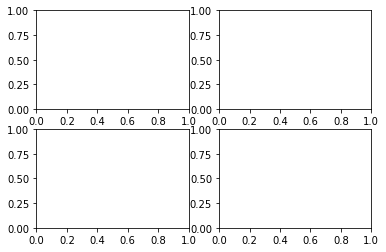

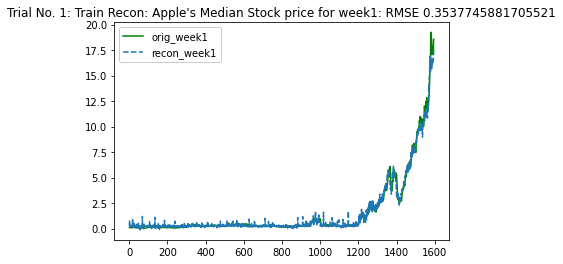

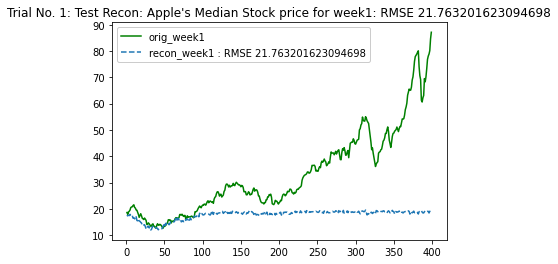

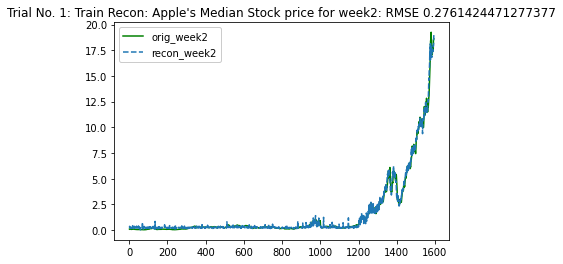

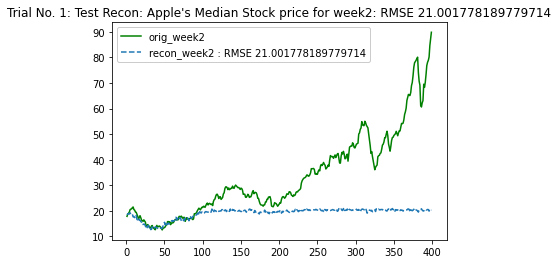

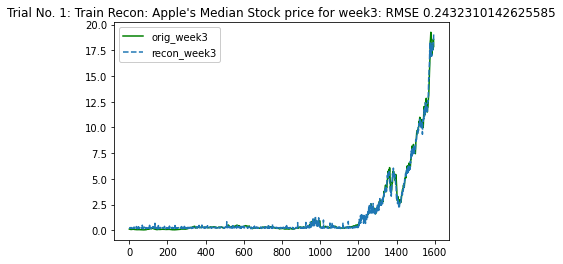

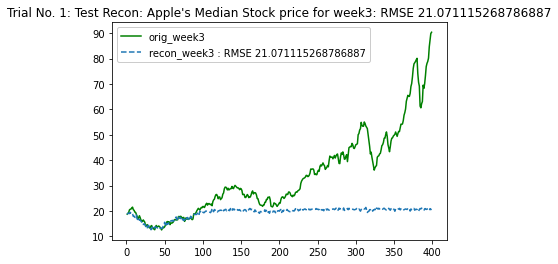

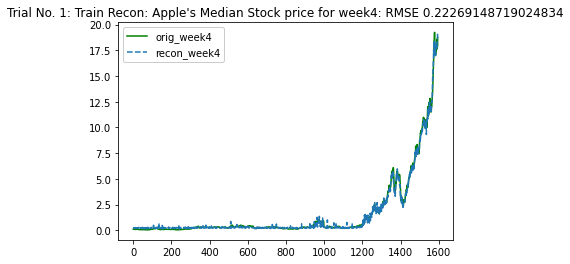

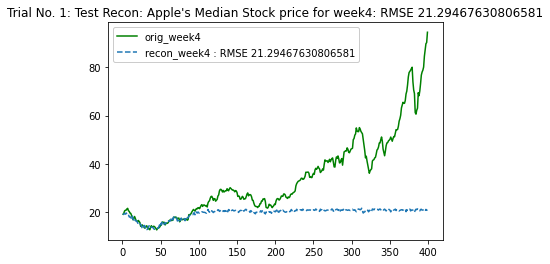

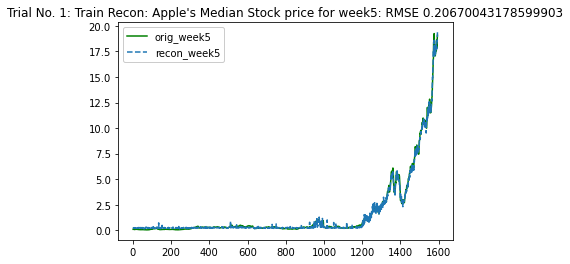

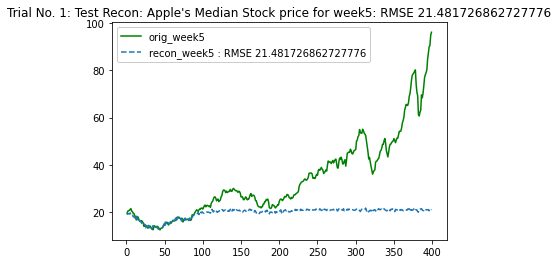

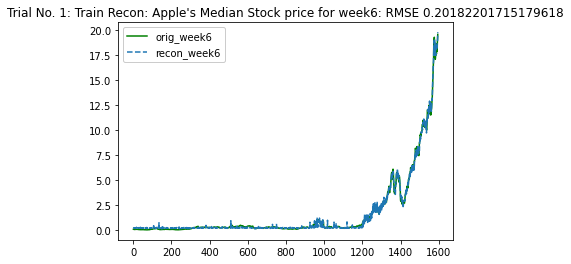

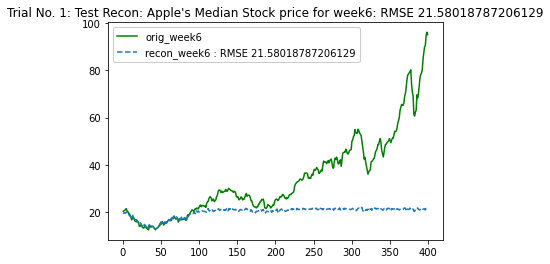

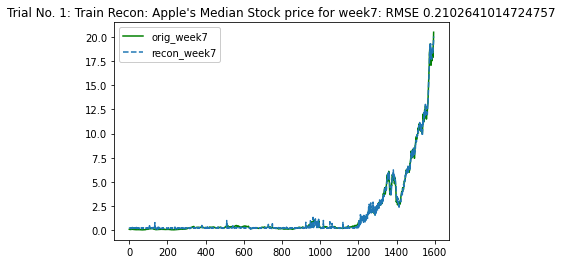

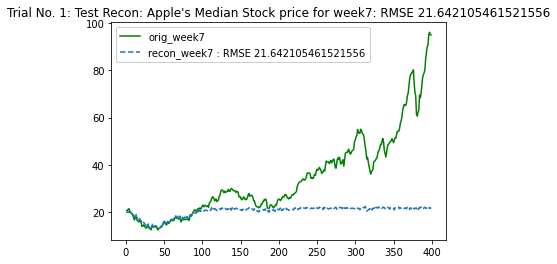

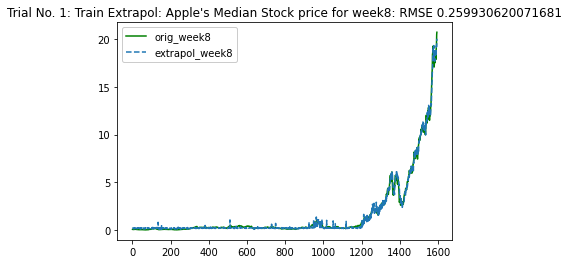

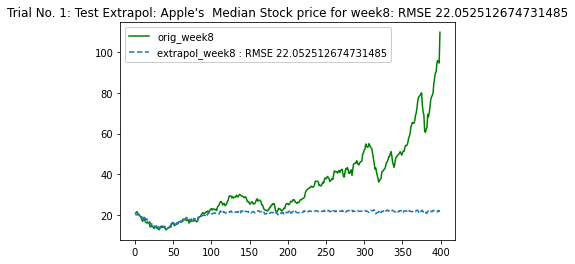

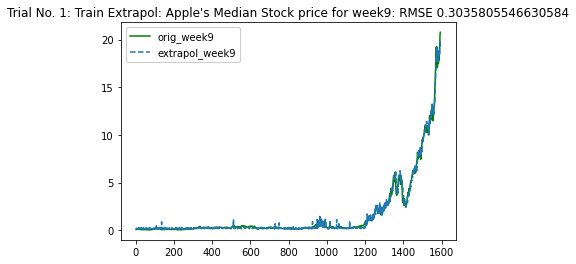

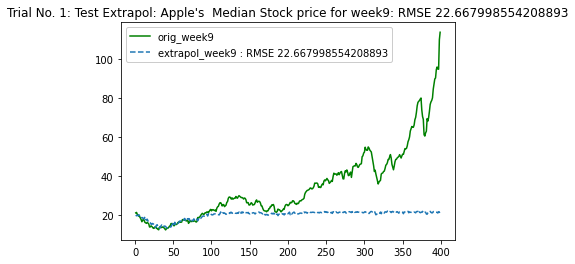

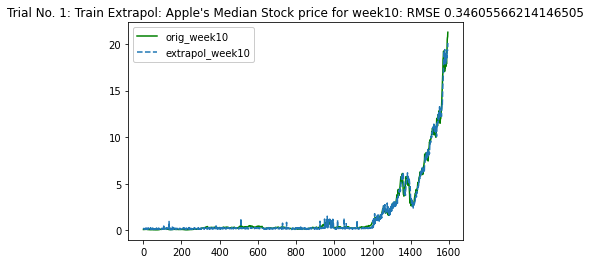

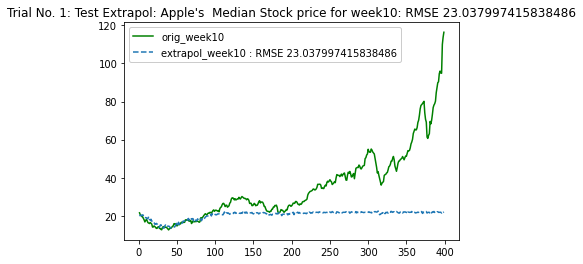

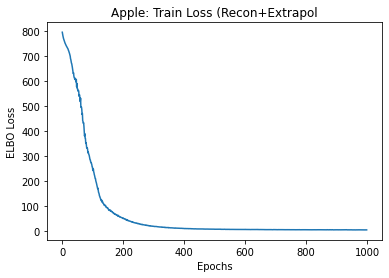

In [ ]:
# Plots
fig, axes = plt.subplots(2, 2)
for i in range(1, lag+forecast+1):
    if i<=lag:
        plot_train_recon(i, train_y_recon, pred_train_recon, fig, axes)
        plot_test_recon(i, test_y_recon, pred_test_recon, fig, axes)
    elif i>lag:
        plot_train_extrapol(i, train_y_extrapol, pred_train_extrapol, fig, axes)
        plot_test_extrapol(i, test_y_extrapol, pred_test_extrapol, fig, axes)
plot_loss(loss_list)

In [ ]:
# RMSE Table
recon_rmse_filepath = f"results-latentode/{tickerName}-trial{trial}-recon-rmse.csv"
extrapol_rmse_filepath = f"results-latentode/{tickerName}-trial{trial}-extrapol-rmse.csv"
recon_rmse_data, extrapol_rmse_data = rmse_table(recon_rmse_filepath, extrapol_rmse_filepath, train_y_recon, pred_train_recon, train_y_extrapol, pred_train_extrapol, test_y_recon, pred_test_recon, test_y_extrapol, pred_test_extrapol)

In [ ]:
tickerName = 'Apple'
trial = 1
pd.read_csv(f"results-latentode/{tickerName}-trial{trial}-recon-rmse.csv", index_col=0)


,week,train_recon_rmse,test_recon_rmse
0,1,0.353775,21.763202
1,2,0.276142,21.001778
2,3,0.243231,21.071115
3,4,0.222691,21.294676
4,5,0.206700,21.481727
5,6,0.201822,21.580188
6,7,0.210264,21.642105


In [ ]:
pd.read_csv(f"results-latentode/{tickerName}-trial{trial}-extrapol-rmse.csv", index_col=0)


,week,train_extrapol_rmse,test_extrapol_rmse
0,8,0.259931,22.052513
1,9,0.303581,22.667999
2,10,0.346056,23.037997


### Apple: Trial 2

In [3]:
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd 
from pandas import concat
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
from torchdiffeq.torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dict_tickers = {
    'Apple': 'AAPL',
    'Microsoft': 'MSFT',
    'Google': 'GOOG',
    'Bitcoin': 'BTC-USD',
    'Facebook': 'FB',
    'Walmart': 'WMT',
    'Amazon': 'AMZN',
    'CVS': 'CVS',
    'Berkshire': 'BRK-B',
    'ExxonMobil': 'XOM',
    'AtandT': 'T',
    'Costco': 'COST',
    'Walgreens': 'WBA',
    'Kroger': 'KR',
    'JPMorgan': 'JPM',
    'Verizon': 'VZ',
    'FordMotor': 'F',
    'GeneralMotors': 'GM',
    'Dell': 'DELL',
    'BankOfAmerica': 'BAC',
    'Target': 'TGT',
    'GeneralElectric': 'GE',
    'JohnsonandJohnson': 'JNJ',
    'Nvidia': 'NVDA',
    'Intel': 'INTC',
}

def stockDataTransformer(filepath):
    df = pd.read_csv(filepath)
    df.set_index('Date', inplace=True)
    df1 = df[['Open', 'Close']].copy()
    data = df1.values
    n_samples = data.shape[0]//10*10
    reshape_number = n_samples*data.shape[1]//10
    data1 = data[:n_samples].reshape((reshape_number, 10))
    return data1

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def get_median(array, axis = 1):
    # https://numpy.org/doc/stable/reference/generated/numpy.median.html
    return np.median(array, axis = axis).reshape(data_size, 1)  #, keepdims=True)

def split_data(perc_train, perc_valid, lag, data_orig, data_m1, n_features_orig, n_features_median):
    values = data_m1
    
    sizeOfReframed = len(data_m1)
    len_train = int(perc_train*sizeOfReframed) # int(sizeOfReframed - len_test) # - len_valid)
    train_data_orig = data_orig[:len_train, :]
    # valid = values[len_train:len_valid+len_train, :]
    test_data_orig = data_orig[len_train:, :]  # [len_valid+len_train:, :]
    # n_features = n_features
    
    train_data_ml = values[:len_train, :]
    test_data_ml = values[len_train:, :] 
    # split into input and outputs
    n_obs = lag * n_features_orig
    n_obs_median = (lag+forecast) * n_features_median
    train_X, train_y = train_data_orig[:, :n_obs], train_data_ml[:, :n_obs_median]
    test_X, test_y = test_data_orig[:, :n_obs], test_data_ml[:, :n_obs_median]
    # valid_X, valid_y = valid[:, :n_obs], valid[:, -1]
    print(train_X.shape, len(train_X), train_y.shape)
    
    # reshape input to be 3D [samples, features, lag]
    train_X = train_X.reshape((train_X.shape[0], n_features_orig, lag))
    test_X = test_X.reshape((test_X.shape[0], n_features_orig, lag))
    # valid_X = valid_X.reshape((valid_X.shape[0], lag, n_features))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)  # , valid_X.shape, valid_y.shape)
    
    # Get the reconstruction train_y, test_y and extrapolated train_y, test_y
    train_y_recon, train_y_extrapol = train_y[:, :lag], train_y[:, lag:]
    test_y_recon, test_y_extrapol = test_y[:, :lag], test_y[:, lag:]
    dataload = {
        'train_data_orig': train_data_orig,
        'test_data_orig': test_data_orig,
        'train_data_ml': train_data_ml,
        'test_data_ml': test_data_ml,
        # 'valid': valid,
        'train_X': train_X,
        'train_y': train_y,
        'test_X': test_X,
        'test_y': test_y,
        'n_features_orig': n_features_orig,
        'n_features_median': n_features_median,
        'n_obs': n_obs,
        'n_obs_median': n_obs_median,
        # 'valid_X': valid_X,
        # 'valid_y': valid_y,
        'train_y_recon': train_y_recon,
        'train_y_extrapol': train_y_extrapol,
        'test_y_recon': test_y_recon,
        'test_y_extrapol': test_y_extrapol
    }
    
    return dataload

# https://discuss.pytorch.org/t/rmse-loss-function/16540/3
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss
class LatentODEfunc(nn.Module):

    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x).to(device)
        out = self.elu(out).to(device)
        out = self.fc2(out).to(device)
        out = self.elu(out).to(device)
        out = self.fc3(out).to(device)
        return out

class RecognitionRNN(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=5, nhidden=25, nbatch=1):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.i2h = self.i2h.float()
        self.h2o = nn.Linear(nhidden, latent_dim * 2)
        self.h2o = self.h2o.float()

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1).to(device)
        h = torch.tanh(self.i2h(combined.float())).to(device)
        out = self.h2o(h).to(device)
        return out, h

    def initHidden(self):
        return torch.zeros(self.nbatch, self.nhidden)

class Decoder(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=5, nhidden=20):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.fc1(z).to(device)
        out = self.relu(out).to(device)
        out = self.fc2(out).to(device)
        return out

class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float().to(x.device).to(device)
    const = torch.log(const).to(device)
    return -.5 * (const + logvar + (x - mean) ** 2. / torch.exp(logvar))

def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl.to(device)

def train(loss_str, niters):
    loss_list = []
    for itr in range(1, niters + 1):
    
        optimizer.zero_grad()
        # backward in time to infer q(z_0)
        h = rec.initHidden().to(device)  # (# nbatches_train, rnn_hidden)
        for t_r in reversed(range(train_X.shape[2])):  # input_dimension
            obs = train_X[:, :, t_r].to(device)
            # obs = torch.reshape(obs, (1, 1)).to(device)
            out, h = rec.forward(obs, h)
        qz0_mean, qz0_logvar = out[:, :latent_dim].to(device), out[:, latent_dim:].to(device)
        epsilon = torch.randn(qz0_mean.size()).to(device)
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

        # forward in time and solve ode for reconstructions
        pred_z = odeint(func, z0, t.to(device)).permute(1, 0, 2)  # [:, -1, :]
        pred_x = dec(pred_z).to(device)
        pred_x = torch.reshape(pred_x, (train_X.shape[0], lag+forecast)).to(device)

        # compute loss
        if loss_str == 'mse':
            loss = torch.nn.MSELoss()(pred_x.float(), train_X[i, :, :].float().to(device)).float()
        elif loss_str == 'elbo':
            noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
            noise_logvar = 2. * torch.log(noise_std_).to(device)
            logpx = log_normal_pdf(
                train_y[:, 0, :].to(device), pred_x, noise_logvar).sum(-1)  # .sum(-1)
            pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
            analytic_kl = normal_kl(qz0_mean, qz0_logvar,
                                    pz0_mean, pz0_logvar).sum(-1)
            loss = torch.mean(-logpx + analytic_kl, dim=0).to(device)
            # loss = torch.reshape(loss, (1, 1)).to(device)
        loss_list.append(loss)
            # loss_ = torch.mean(torch.cat([x.float() for x in loss_list])).to(device)  
        loss.backward()
        optimizer.step()
        # loss_meter.update(loss.item())
        if itr%10==0:
            print('Iter: {}, running: {:.4f}'.format(itr, loss.item()))
    return loss_list

def train_loss(h):
    train_loss = 0.0
    predictions = []
    
    for t_r in reversed(range(train_X.shape[2])):
        obs = train_X[:, :, t_r].to(device)
        # obs = torch.reshape(obs, (1, 1)).to(device)
        out, h = rec.forward(obs, h)

    qz0_mean, qz0_logvar = out[:, :latent_dim].to(device), out[:, latent_dim:].to(device)
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

    # forward in time and solve ode for reconstructions
    pred_z = odeint(func, z0, t.to(device)).permute(1, 0, 2)
    pred_x = dec(pred_z).to(device)
    pred_x = torch.reshape(pred_x, (pred_x.shape[0], 1, lag+forecast))
    pred_x_recon = pred_x[:, :, :lag]
    pred_x_extrapol = pred_x[:, :, lag:]
    rmse = RMSELoss()
    # loss = torch.nn.MSELoss()(pred_x, train_X[:, :, :].to(device))
    loss_recon = rmse(pred_x_recon, train_y_recon)
    loss_extrapol = rmse(pred_x_extrapol, train_y_extrapol)
    # train_loss += loss
    # predictions.append(pred_x)
    
    # train_loss = torch.sqrt(train_loss)
    # train_pred = torch.cat([x.float() for x in predictions])
    # train_pred = torch.reshape(train_pred, (train_pred.shape[0], 1, lag))
    with torch.no_grad():
        print('Train: Reconstruction Loss')
        print('Total Train Loss {:.6f}'.format(loss_recon.item()))
        print('Train: Extrapolation Loss')
        print('Total Train Extrapolation Loss {:.6f}'.format(loss_extrapol.item()))
    return pred_x, pred_x_recon, pred_x_extrapol

def test_loss(h, t_test):
    # print(h.shape)
    test_loss = 0.0
    predictions = []
    rmse = RMSELoss()
    for t_r in reversed(range(test_X.shape[2])):
        obs = test_X[:, :, t_r].to(device)
        # obs = torch.reshape(obs, (1, 1)).to(device)
        out, h = rec.forward(obs, h)
    qz0_mean, qz0_logvar = out[:, :latent_dim].to(device), out[:, latent_dim:].to(device)
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

    # forward in time and solve ode for reconstructions
    pred_z = odeint(func, z0, t_test).permute(1, 0, 2).to(device)
    pred_x = dec(pred_z).to(device)
    pred_x = torch.reshape(pred_x, (pred_x.shape[0], 1, lag+forecast))
    pred_x_recon = pred_x[:, :, :lag]
    pred_x_extrapol = pred_x[:, :, lag:]
    # pred_test_X = torch.reshape(pred_test_X, (pred_test_X.shape[0], pred_test_X.shape[1]))
    # pred_test_y = torch.reshape(pred_test_y, (1, pred_test_y.shape[0], 1, lag))
    # print(test_pred_y.shape)
    rmse = RMSELoss()
    # loss = torch.nn.MSELoss()(pred_x, train_X[i, :, :].to(device))
    loss_recon = rmse(pred_x_recon, test_y_recon)
    loss_extrapol = rmse(pred_x_extrapol, test_y_extrapol)

    # loss = torch.nn.MSELoss()(pred_x, torch.reshape(test_X[i, :, :].to(device), (1, 5))).to(device)
    # test_loss += loss
    # predictions.append(pred_x)
    
    # test_loss = torch.sqrt(test_loss)
    # test_pred = torch.cat([x.float() for x in predictions])
    
    # loss = torch.nn.MSELoss()(test_pred_y[train_size-test_size:, batch_time2-2, :], label_batch_y[train_size-test_size:, batch_time2-2, :])
    with torch.no_grad():
        print('Test: Reconstruction Loss')
        print('Total Loss {:.6f}'.format(loss_recon.item()))
        print('Test: Extrapolation Loss')
        print('Total Loss {:.6f}'.format(loss_extrapol.item()))
    return pred_x, pred_x_recon, pred_x_extrapol

def plot_train_recon(i, train_y_recon, pred_y_recon, fig, axes):
    t_ = torch.linspace(1., train_y_recon.shape[0], train_y_recon.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), train_y_recon.cpu().numpy()[:, :, i-1], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((train_y_recon.cpu().numpy()[:, :, i-1] - pred_y_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_recon.cpu().numpy()[:, :, i-1], '--', label = f"recon_week{i}")
    plt.title(f"Trial No. {trial}: Train Recon: {tickerName}'s Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Train Recon: {tickerName}'s Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_train_extrapol(i, train_y_extrapol, pred_y_extrapol, fig, axes):
    t_ = torch.linspace(1., train_y_extrapol.shape[0], train_y_extrapol.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), train_y_extrapol.cpu().numpy()[:, :, i-1-lag], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((train_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_y_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_extrapol.cpu().numpy()[:, :, i-1-lag], '--', label = f"extrapol_week{i}")
    plt.title(f"Trial No. {trial}: Train Extrapol: {tickerName}'s Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Train Extrapol: {tickerName}'s Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_test_recon(i, test_y_recon, pred_y_recon, fig, axes):
    t_ = torch.linspace(1., test_y_recon.shape[0], test_y_recon.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), test_y_recon.cpu().numpy()[:, :, i-1], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((test_y_recon.cpu().numpy()[:, :, i-1] - pred_y_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_recon.cpu().numpy()[:, :, i-1], '--', label = f"recon_week{i} : RMSE {rmse}")
    plt.title(f"Trial No. {trial}: Test Recon: {tickerName}'s Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Test Recon: {tickerName}'s Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_test_extrapol(i, test_y_extrapol, pred_y_extrapol, fig, axes):
    t_ = torch.linspace(1., test_y_extrapol.shape[0], test_y_extrapol.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), test_y_extrapol.cpu().numpy()[:, :, i-1-lag], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((test_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_y_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_extrapol.cpu().numpy()[:, :, i-1-lag], '--', label = f"extrapol_week{i} : RMSE {rmse}")
    plt.title(f"Trial No. {trial}: Test Extrapol: {tickerName}'s  Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Test Extrapol: {tickerName}'s  Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_loss(loss_list):
    plt.plot(loss_list)
    plt.title(f'{tickerName}: Train Loss (Recon+Extrapol')
    plt.ylabel('ELBO Loss')
    plt.xlabel('Epochs')
    plt.savefig(f"plots-latentode/{tickerName}: Trial No. {trial}: ELBO Train Loss.pdf", dpi = 150)
    plt.show()

def rmse_table(recon_rmse_filepath, extrapol_rmse_filepath, train_y_recon, pred_train_recon, train_y_extrapol, pred_train_extrapol, test_y_recon, pred_test_recon, test_y_extrapol, pred_test_extrapol):
    recon_rmse_data = {
        'week': list(),
        'train_recon_rmse': list(),
        'test_recon_rmse': list()
    }

    extrapol_rmse_data = {
        'week': list(),
        'train_extrapol_rmse': list(),
        'test_extrapol_rmse': list()
    }
    for i in range(1, lag+forecast+1):
        with torch.no_grad():
            if i<=lag:
                recon_rmse_data['week'].append(i)
                train_recon_rmse = np.sqrt(((train_y_recon.cpu().numpy()[:, :, i-1] - pred_train_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
                recon_rmse_data['train_recon_rmse'].append(train_recon_rmse)
                test_recon_rmse = np.sqrt(((test_y_recon.cpu().numpy()[:, :, i-1] - pred_test_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
                recon_rmse_data['test_recon_rmse'].append(test_recon_rmse)
            elif i>lag:
                extrapol_rmse_data['week'].append(i)
                train_extrapol_rmse = np.sqrt(((train_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_train_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
                extrapol_rmse_data['train_extrapol_rmse'].append(train_extrapol_rmse)
                test_extrapol_rmse = np.sqrt(((test_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_test_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
                extrapol_rmse_data['test_extrapol_rmse'].append(test_extrapol_rmse)
    recon_rmse_df = pd.DataFrame(recon_rmse_data)
    recon_rmse_df.to_csv(recon_rmse_filepath)
    extrapol_rmse_df = pd.DataFrame(extrapol_rmse_data)
    extrapol_rmse_df.to_csv(extrapol_rmse_filepath)

    return recon_rmse_data, extrapol_rmse_data


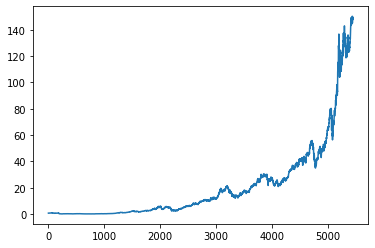

In [5]:
apple = pd.read_csv(f"raw-stock-data/data-2000-2021/Apple.csv")
plt.plot(apple['Open'].values)

In [6]:

# FileName
tickerName = 'Apple'
# Filepath
filepath = f"raw-stock-data/data-2000-2021/{tickerName}.csv"
# Get the data in the required format
data = stockDataTransformer(filepath)
print('Data after Data Transformation')
# # Total Data Size
data_size = data.shape[0]

print(pd.DataFrame(data))
print('\n')

lag = 7
forecast = 3
data_orig = series_to_supervised(data, lag, forecast).values
print('Data Original after series to supervised on data')
print(data_orig.shape)
print(pd.DataFrame(data_orig))
print('\n')

median_data = get_median(data)
print('Median data')
# Median data for each week
print(median_data.shape)
print(pd.DataFrame(median_data, columns = ['median_stockprice_week']).head(10))
print('\n')

# Convert median_data to (n_samples, 5) matrix
data_m1 = series_to_supervised(median_data, lag, forecast).values
print('Median data after series to supervised')
print(data_m1.shape)
print(pd.DataFrame(data_m1, columns = [f"week i+{i}" for i in range(1, lag+forecast+1)]))
print('\n')

dataload = split_data(0.9, 0, lag, data_orig, data_m1, data.shape[1], 1)

print('Get Train and Test data')
train_X = torch.from_numpy(dataload['train_X']).to(device)
print(f"train_X shape: {train_X.shape}")  # (#training, 1, 5)

train_y = torch.from_numpy(dataload['train_y']).to(device)
print(f"train_y shape: {train_y.shape}")  # (#training, 5)
train_y = torch.reshape(train_y, (train_X.shape[0], 1, train_y.shape[1])).to(device)
print(f"train_y shape: {train_y.shape}")  # (#training, 1, 5)
test_X = torch.from_numpy(dataload['test_X']).to(device)
print(f"test_X.shape : {test_X.shape}")  # (#testing, 1, 5)
test_y = torch.from_numpy(dataload['test_y']).to(device)
print(f"test_y.shape : {test_y.shape}")  # (#testing, 5)
test_y = torch.reshape(test_y, (test_X.shape[0], 1, test_y.shape[1])).to(device)
print(f"test_y.shape : {test_y.shape}")

train_y_recon = torch.from_numpy(dataload['train_y_recon']).to(device)
train_y_recon = torch.reshape(train_y_recon, (train_y_recon.shape[0], 1,train_y_recon.shape[1]))
train_y_extrapol = torch.from_numpy(dataload['train_y_extrapol']).to(device)
train_y_extrapol = torch.reshape(train_y_extrapol, (train_y_extrapol.shape[0], 1, train_y_extrapol.shape[1]))
test_y_recon = torch.from_numpy(dataload['test_y_recon']).to(device)
test_y_recon = torch.reshape(test_y_recon, (test_y_recon.shape[0], 1, test_y_recon.shape[1]))
test_y_extrapol = torch.from_numpy(dataload['test_y_extrapol']).to(device)
test_y_extrapol = torch.reshape(test_y_extrapol, (test_y_extrapol.shape[0], 1, test_y_extrapol.shape[1]))
print(f"train_y_recon.shape : {train_y_recon.shape}")
print(f"train_y_extrapol.shape : {train_y_extrapol.shape}")
print(f"test_y_recon.shape : {test_y_recon.shape}")
print(f"test_y_extrapol.shape : {test_y_extrapol.shape}")
print('\n')

trial = 2
# predictions on test_data's time size (test_size-batch_time, 1)
# Time steps
t = torch.linspace(0, lag+forecast-1, lag+forecast).to(device)
print(f"t.shape : {t.shape}")

latent_dim = 50
nhidden = 100
rnn_nhidden = 125
obs_dim = data.shape[1]
out_dim = 1
noise_std = .3

lr = 0.001
loss_str = 'elbo'
# all_values = True
niters = 2000  # training epochs

Data after Data Transformation
               0           1           2  ...           7           8           9
0       0.803995    0.858137    0.829868  ...    0.728291    0.739790    0.762789
1       0.781954    0.749373    0.735478  ...    0.741706    0.766622    0.769976
2       0.774288    0.796807    0.809744  ...    0.853346    0.831306    0.814536
3       0.804953    0.860533    0.843284  ...    0.779079    0.774288    0.795370
4       0.797286    0.768538    0.772372  ...    0.827952    0.827952    0.874428
...          ...         ...         ...  ...         ...         ...         ...
1085  148.896905  146.550430  144.593363  ...  145.641785  146.141047  145.302307
1086  145.591857  147.139542  147.049692  ...  146.139999  146.199997  146.089996
1087  146.440002  145.600006  146.050003  ...  149.100006  148.539993  151.119995
1088  150.229996  150.190002  149.800003  ...  148.190002  148.309998  149.710007
1089  149.449997  149.619995  149.809998  ...  148.600006  149.0000

In [7]:
## Training
# model
nbatches_train = train_X.shape[0]
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nbatches_train).to(device)
dec = Decoder(latent_dim, out_dim, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
optimizer = optim.Adam(params, lr=lr)
loss_list = train(loss_str, niters)




Iter: 10, running: 11947.0661
Iter: 20, running: 6514.0665
Iter: 30, running: 2776.2506
Iter: 40, running: 1226.3510
Iter: 50, running: 621.1459
Iter: 60, running: 377.8199
Iter: 70, running: 283.7027
Iter: 80, running: 234.2667
Iter: 90, running: 206.0565
Iter: 100, running: 188.3551
Iter: 110, running: 182.0974
Iter: 120, running: 171.4242
Iter: 130, running: 163.4174
Iter: 140, running: 158.0662
Iter: 150, running: 156.0865
Iter: 160, running: 151.3918
Iter: 170, running: 144.0733
Iter: 180, running: 141.8492
Iter: 190, running: 142.4666
Iter: 200, running: 139.3035
Iter: 210, running: 132.7947
Iter: 220, running: 132.2265
Iter: 230, running: 122.8694
Iter: 240, running: 122.8176
Iter: 250, running: 127.4155
Iter: 260, running: 129.4273
Iter: 270, running: 112.1742
Iter: 280, running: 112.0598
Iter: 290, running: 107.6002
Iter: 300, running: 106.5548
Iter: 310, running: 104.1095
Iter: 320, running: 106.3473
Iter: 330, running: 99.3088
Iter: 340, running: 97.9710
Iter: 350, running: 

FileNotFoundError: ignored

In [8]:
# https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_models_for_inference.html
torch.save(func.state_dict(), f"model-latentode/{tickerName}-trial{trial}-func-moresequences.pth")
torch.save(rec.state_dict(), f"model-latentode/{tickerName}-trial{trial}-rec-moresequences.pth")
torch.save(dec.state_dict(), f"model-latentode/{tickerName}-trial{trial}-dec-moresequences.pth")

func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nbatches_train).to(device)
dec = Decoder(latent_dim, out_dim, nhidden).to(device)

func.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-func-moresequences.pth"))  # f"model-latentode/{tickerName}-trial{trial}-func-moresequences.pth"
rec.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-rec-moresequences.pth"))  # f"model-latentode/{tickerName}-trial{trial}-rec-moresequences.pth"
dec.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-dec-moresequences.pth"))  # f"model-latentode/{tickerName}-trial{trial}-dec-moresequences.pth"

h = rec.initHidden().to(device)
pred_train, pred_train_recon, pred_train_extrapol = train_loss(h)

# Testing
# model

nbatches_test = test_X.shape[0]
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nbatches_test).to(device)
dec = Decoder(latent_dim, out_dim, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))

func.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-func-moresequences.pth"))
rec.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-rec-moresequences.pth"))
dec.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-dec-moresequences.pth")) 

h = rec.initHidden().to(device)
pred_test, pred_test_recon, pred_test_extrapol = test_loss(h, t)

Train: Reconstruction Loss
Total Train Loss 0.587500
Train: Extrapolation Loss
Total Train Extrapolation Loss 0.919827
Test: Reconstruction Loss
Total Loss 37.814980
Test: Extrapolation Loss
Total Loss 49.472126


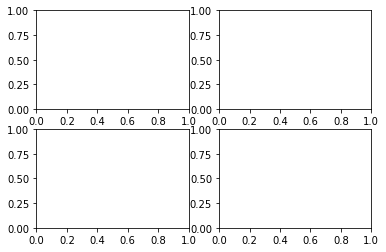

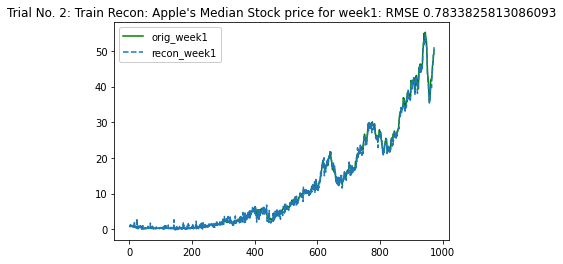

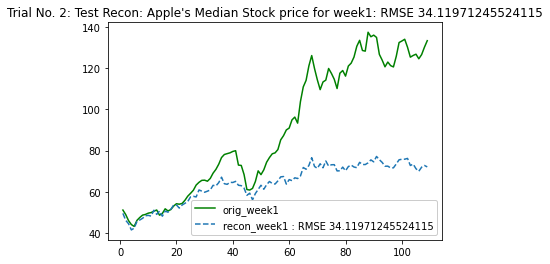

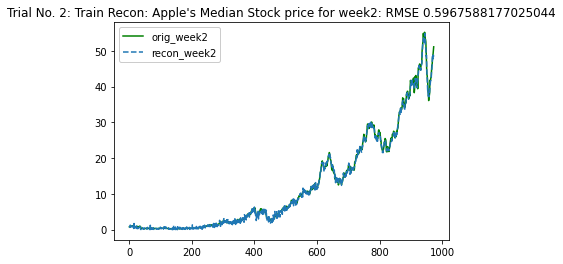

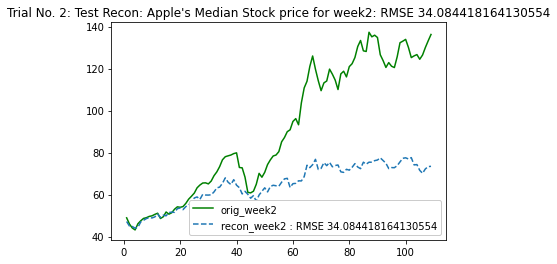

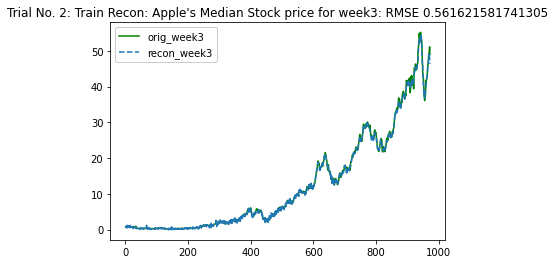

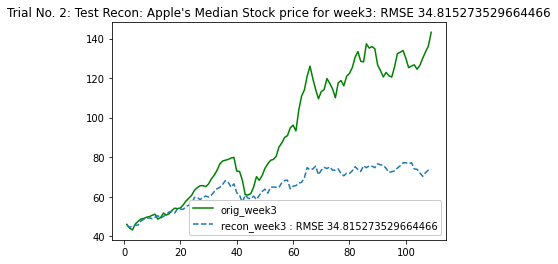

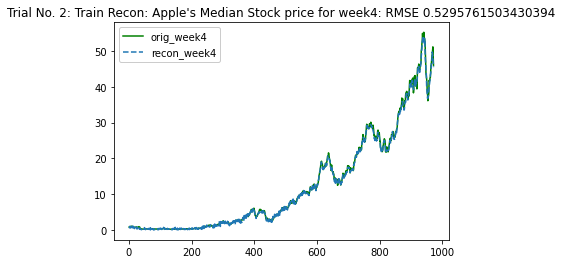

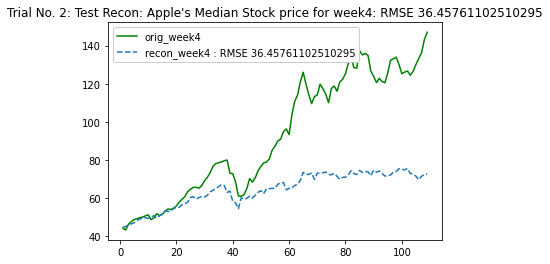

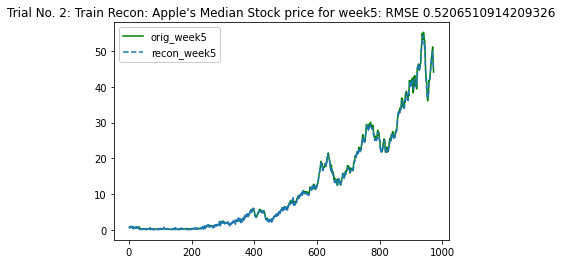

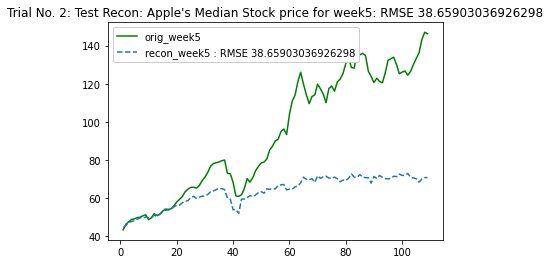

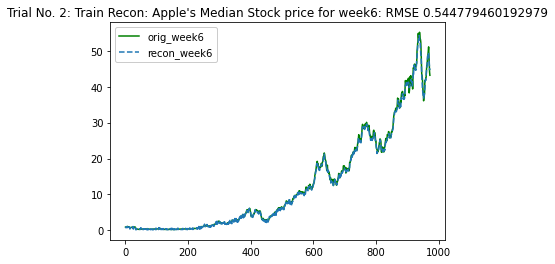

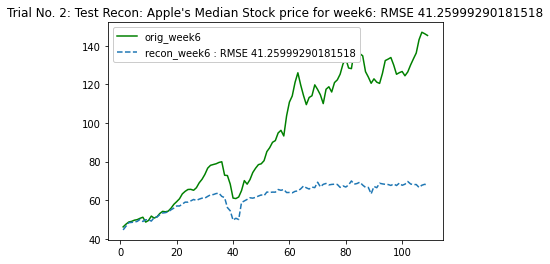

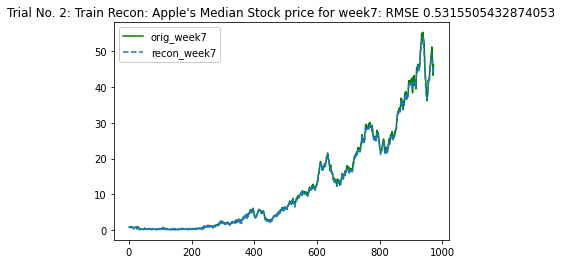

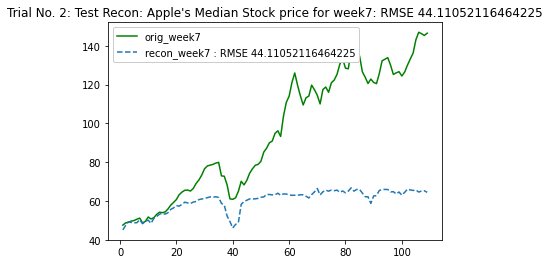

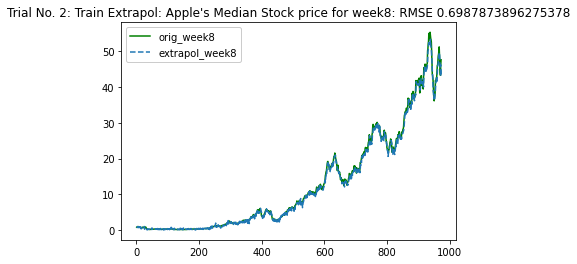

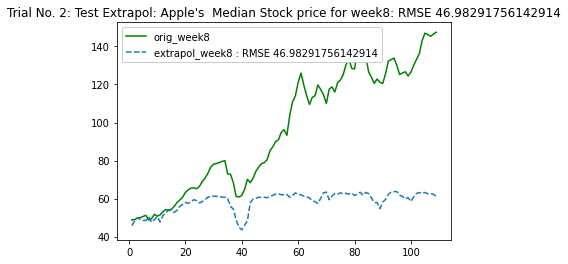

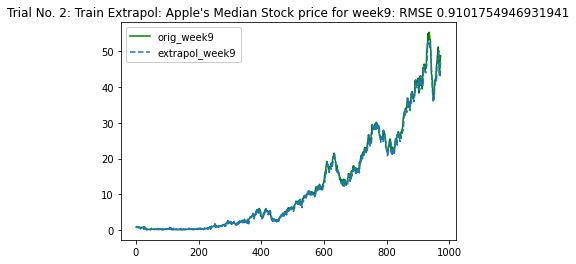

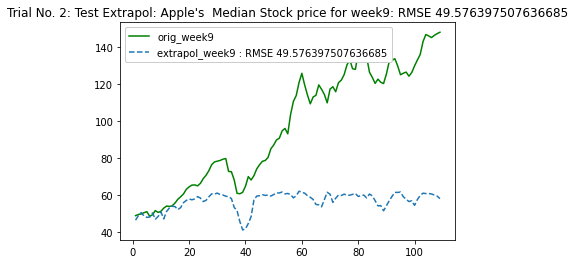

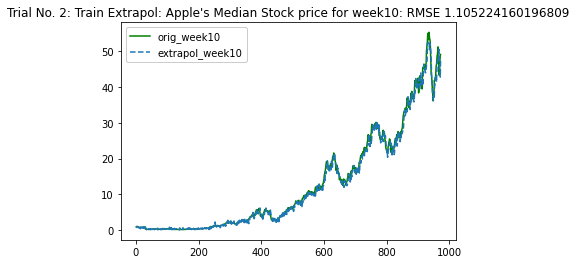

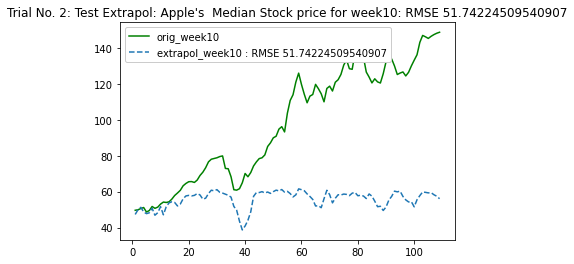

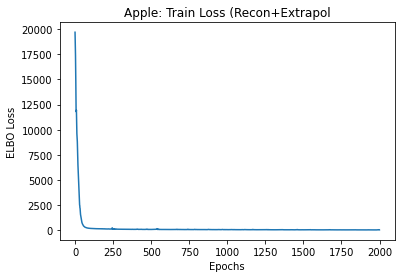

In [9]:
# Plots
fig, axes = plt.subplots(2, 2)
for i in range(1, lag+forecast+1):
    if i<=lag:
        plot_train_recon(i, train_y_recon, pred_train_recon, fig, axes)
        plot_test_recon(i, test_y_recon, pred_test_recon, fig, axes)
    elif i>lag:
        plot_train_extrapol(i, train_y_extrapol, pred_train_extrapol, fig, axes)
        plot_test_extrapol(i, test_y_extrapol, pred_test_extrapol, fig, axes)
plot_loss(loss_list)

In [10]:
# RMSE Table
recon_rmse_filepath = f"results-latentode/{tickerName}-trial{trial}-recon-rmse.csv"
extrapol_rmse_filepath = f"results-latentode/{tickerName}-trial{trial}-extrapol-rmse.csv"
recon_rmse_data, extrapol_rmse_data = rmse_table(recon_rmse_filepath, extrapol_rmse_filepath, train_y_recon, pred_train_recon, train_y_extrapol, pred_train_extrapol, test_y_recon, pred_test_recon, test_y_extrapol, pred_test_extrapol)

pd.read_csv(f"results-latentode/{tickerName}-trial{trial}-recon-rmse.csv", index_col=0)

,week,train_recon_rmse,test_recon_rmse
0,1,0.783383,34.119712
1,2,0.596759,34.084418
2,3,0.561622,34.815274
3,4,0.529576,36.457611
4,5,0.520651,38.659030
5,6,0.544779,41.259993
6,7,0.531551,44.110521


In [11]:
pd.read_csv(f"results-latentode/{tickerName}-trial{trial}-extrapol-rmse.csv", index_col=0)

,week,train_extrapol_rmse,test_extrapol_rmse
0,8,0.698787,46.982918
1,9,0.910175,49.576398
2,10,1.105224,51.742245


### ExxonMobil: Trial 1

In [ ]:
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd 
from pandas import concat
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
from torchdiffeq.torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dict_tickers = {
    'Apple': 'AAPL',
    'Microsoft': 'MSFT',
    'Google': 'GOOG',
    'Bitcoin': 'BTC-USD',
    'Facebook': 'FB',
    'Walmart': 'WMT',
    'Amazon': 'AMZN',
    'CVS': 'CVS',
    'Berkshire': 'BRK-B',
    'ExxonMobil': 'XOM',
    'AtandT': 'T',
    'Costco': 'COST',
    'Walgreens': 'WBA',
    'Kroger': 'KR',
    'JPMorgan': 'JPM',
    'Verizon': 'VZ',
    'FordMotor': 'F',
    'GeneralMotors': 'GM',
    'Dell': 'DELL',
    'BankOfAmerica': 'BAC',
    'Target': 'TGT',
    'GeneralElectric': 'GE',
    'JohnsonandJohnson': 'JNJ',
    'Nvidia': 'NVDA',
    'Intel': 'INTC',
}

def stockDataTransformer(filepath):
    df = pd.read_csv(filepath)
    df.set_index('Date', inplace=True)
    df1 = df[['Open', 'Close']].copy()
    data = df1.values
    n_samples = data.shape[0]//10*10
    reshape_number = n_samples*data.shape[1]//10
    data1 = data[:n_samples].reshape((reshape_number, 10))
    return data1

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def get_median(array, axis = 1):
    # https://numpy.org/doc/stable/reference/generated/numpy.median.html
    return np.median(array, axis = axis).reshape(data_size, 1)  #, keepdims=True)

def split_data(perc_train, perc_valid, lag, data_orig, data_m1, n_features_orig, n_features_median):
    values = data_m1
    
    sizeOfReframed = len(data_m1)
    len_train = int(perc_train*sizeOfReframed) # int(sizeOfReframed - len_test) # - len_valid)
    train_data_orig = data_orig[:len_train, :]
    # valid = values[len_train:len_valid+len_train, :]
    test_data_orig = data_orig[len_train:, :]  # [len_valid+len_train:, :]
    # n_features = n_features
    
    train_data_ml = values[:len_train, :]
    test_data_ml = values[len_train:, :] 
    # split into input and outputs
    n_obs = lag * n_features_orig
    n_obs_median = (lag+forecast) * n_features_median
    train_X, train_y = train_data_orig[:, :n_obs], train_data_ml[:, :n_obs_median]
    test_X, test_y = test_data_orig[:, :n_obs], test_data_ml[:, :n_obs_median]
    # valid_X, valid_y = valid[:, :n_obs], valid[:, -1]
    print(train_X.shape, len(train_X), train_y.shape)
    
    # reshape input to be 3D [samples, features, lag]
    train_X = train_X.reshape((train_X.shape[0], n_features_orig, lag))
    test_X = test_X.reshape((test_X.shape[0], n_features_orig, lag))
    # valid_X = valid_X.reshape((valid_X.shape[0], lag, n_features))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)  # , valid_X.shape, valid_y.shape)
    
    # Get the reconstruction train_y, test_y and extrapolated train_y, test_y
    train_y_recon, train_y_extrapol = train_y[:, :lag], train_y[:, lag:]
    test_y_recon, test_y_extrapol = test_y[:, :lag], test_y[:, lag:]
    dataload = {
        'train_data_orig': train_data_orig,
        'test_data_orig': test_data_orig,
        'train_data_ml': train_data_ml,
        'test_data_ml': test_data_ml,
        # 'valid': valid,
        'train_X': train_X,
        'train_y': train_y,
        'test_X': test_X,
        'test_y': test_y,
        'n_features_orig': n_features_orig,
        'n_features_median': n_features_median,
        'n_obs': n_obs,
        'n_obs_median': n_obs_median,
        # 'valid_X': valid_X,
        # 'valid_y': valid_y,
        'train_y_recon': train_y_recon,
        'train_y_extrapol': train_y_extrapol,
        'test_y_recon': test_y_recon,
        'test_y_extrapol': test_y_extrapol
    }
    
    return dataload

# https://discuss.pytorch.org/t/rmse-loss-function/16540/3
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss
class LatentODEfunc(nn.Module):

    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x).to(device)
        out = self.elu(out).to(device)
        out = self.fc2(out).to(device)
        out = self.elu(out).to(device)
        out = self.fc3(out).to(device)
        return out

class RecognitionRNN(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=5, nhidden=25, nbatch=1):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.i2h = self.i2h.float()
        self.h2o = nn.Linear(nhidden, latent_dim * 2)
        self.h2o = self.h2o.float()

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1).to(device)
        h = torch.tanh(self.i2h(combined.float())).to(device)
        out = self.h2o(h).to(device)
        return out, h

    def initHidden(self):
        return torch.zeros(self.nbatch, self.nhidden)

class Decoder(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=5, nhidden=20):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.fc1(z).to(device)
        out = self.relu(out).to(device)
        out = self.fc2(out).to(device)
        return out

class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float().to(x.device).to(device)
    const = torch.log(const).to(device)
    return -.5 * (const + logvar + (x - mean) ** 2. / torch.exp(logvar))

def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl.to(device)

def train(loss_str, niters):
    loss_list = []
    for itr in range(1, niters + 1):
    
        optimizer.zero_grad()
        # backward in time to infer q(z_0)
        h = rec.initHidden().to(device)  # (# nbatches_train, rnn_hidden)
        for t_r in reversed(range(train_X.shape[2])):  # input_dimension
            obs = train_X[:, :, t_r].to(device)
            # obs = torch.reshape(obs, (1, 1)).to(device)
            out, h = rec.forward(obs, h)
        qz0_mean, qz0_logvar = out[:, :latent_dim].to(device), out[:, latent_dim:].to(device)
        epsilon = torch.randn(qz0_mean.size()).to(device)
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

        # forward in time and solve ode for reconstructions
        pred_z = odeint(func, z0, t.to(device)).permute(1, 0, 2)  # [:, -1, :]
        pred_x = dec(pred_z).to(device)
        pred_x = torch.reshape(pred_x, (train_X.shape[0], lag+forecast)).to(device)

        # compute loss
        if loss_str == 'mse':
            loss = torch.nn.MSELoss()(pred_x.float(), train_X[i, :, :].float().to(device)).float()
        elif loss_str == 'elbo':
            noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
            noise_logvar = 2. * torch.log(noise_std_).to(device)
            logpx = log_normal_pdf(
                train_y[:, 0, :].to(device), pred_x, noise_logvar).sum(-1)  # .sum(-1)
            pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
            analytic_kl = normal_kl(qz0_mean, qz0_logvar,
                                    pz0_mean, pz0_logvar).sum(-1)
            loss = torch.mean(-logpx + analytic_kl, dim=0).to(device)
            # loss = torch.reshape(loss, (1, 1)).to(device)
        loss_list.append(loss)
            # loss_ = torch.mean(torch.cat([x.float() for x in loss_list])).to(device)  
        loss.backward()
        optimizer.step()
        # loss_meter.update(loss.item())
        if itr%10==0:
            print('Iter: {}, running: {:.4f}'.format(itr, loss.item()))
    return loss_list

def train_loss(h):
    train_loss = 0.0
    predictions = []
    
    for t_r in reversed(range(train_X.shape[2])):
        obs = train_X[:, :, t_r].to(device)
        # obs = torch.reshape(obs, (1, 1)).to(device)
        out, h = rec.forward(obs, h)

    qz0_mean, qz0_logvar = out[:, :latent_dim].to(device), out[:, latent_dim:].to(device)
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

    # forward in time and solve ode for reconstructions
    pred_z = odeint(func, z0, t.to(device)).permute(1, 0, 2)
    pred_x = dec(pred_z).to(device)
    pred_x = torch.reshape(pred_x, (pred_x.shape[0], 1, lag+forecast))
    pred_x_recon = pred_x[:, :, :lag]
    pred_x_extrapol = pred_x[:, :, lag:]
    rmse = RMSELoss()
    # loss = torch.nn.MSELoss()(pred_x, train_X[:, :, :].to(device))
    loss_recon = rmse(pred_x_recon, train_y_recon)
    loss_extrapol = rmse(pred_x_extrapol, train_y_extrapol)
    # train_loss += loss
    # predictions.append(pred_x)
    
    # train_loss = torch.sqrt(train_loss)
    # train_pred = torch.cat([x.float() for x in predictions])
    # train_pred = torch.reshape(train_pred, (train_pred.shape[0], 1, lag))
    with torch.no_grad():
        print('Train: Reconstruction Loss')
        print('Total Train Loss {:.6f}'.format(loss_recon.item()))
        print('Train: Extrapolation Loss')
        print('Total Train Extrapolation Loss {:.6f}'.format(loss_extrapol.item()))
    return pred_x, pred_x_recon, pred_x_extrapol

def test_loss(h, t_test):
    # print(h.shape)
    test_loss = 0.0
    predictions = []
    rmse = RMSELoss()
    for t_r in reversed(range(test_X.shape[2])):
        obs = test_X[:, :, t_r].to(device)
        # obs = torch.reshape(obs, (1, 1)).to(device)
        out, h = rec.forward(obs, h)
    qz0_mean, qz0_logvar = out[:, :latent_dim].to(device), out[:, latent_dim:].to(device)
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

    # forward in time and solve ode for reconstructions
    pred_z = odeint(func, z0, t_test).permute(1, 0, 2).to(device)
    pred_x = dec(pred_z).to(device)
    pred_x = torch.reshape(pred_x, (pred_x.shape[0], 1, lag+forecast))
    pred_x_recon = pred_x[:, :, :lag]
    pred_x_extrapol = pred_x[:, :, lag:]
    # pred_test_X = torch.reshape(pred_test_X, (pred_test_X.shape[0], pred_test_X.shape[1]))
    # pred_test_y = torch.reshape(pred_test_y, (1, pred_test_y.shape[0], 1, lag))
    # print(test_pred_y.shape)
    rmse = RMSELoss()
    # loss = torch.nn.MSELoss()(pred_x, train_X[i, :, :].to(device))
    loss_recon = rmse(pred_x_recon, test_y_recon)
    loss_extrapol = rmse(pred_x_extrapol, test_y_extrapol)

    # loss = torch.nn.MSELoss()(pred_x, torch.reshape(test_X[i, :, :].to(device), (1, 5))).to(device)
    # test_loss += loss
    # predictions.append(pred_x)
    
    # test_loss = torch.sqrt(test_loss)
    # test_pred = torch.cat([x.float() for x in predictions])
    
    # loss = torch.nn.MSELoss()(test_pred_y[train_size-test_size:, batch_time2-2, :], label_batch_y[train_size-test_size:, batch_time2-2, :])
    with torch.no_grad():
        print('Test: Reconstruction Loss')
        print('Total Loss {:.6f}'.format(loss_recon.item()))
        print('Test: Extrapolation Loss')
        print('Total Loss {:.6f}'.format(loss_extrapol.item()))
    return pred_x, pred_x_recon, pred_x_extrapol

def plot_train_recon(i, train_y_recon, pred_y_recon, fig, axes):
    t_ = torch.linspace(1., train_y_recon.shape[0], train_y_recon.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), train_y_recon.cpu().numpy()[:, :, i-1], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((train_y_recon.cpu().numpy()[:, :, i-1] - pred_y_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_recon.cpu().numpy()[:, :, i-1], '--', label = f"recon_week{i}")
    plt.title(f"Trial No. {trial}: Train Recon: {tickerName}'s Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Train Recon: {tickerName}'s Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_train_extrapol(i, train_y_extrapol, pred_y_extrapol, fig, axes):
    t_ = torch.linspace(1., train_y_extrapol.shape[0], train_y_extrapol.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), train_y_extrapol.cpu().numpy()[:, :, i-1-lag], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((train_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_y_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_extrapol.cpu().numpy()[:, :, i-1-lag], '--', label = f"extrapol_week{i}")
    plt.title(f"Trial No. {trial}: Train Extrapol: {tickerName}'s Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Train Extrapol: {tickerName}'s Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_test_recon(i, test_y_recon, pred_y_recon, fig, axes):
    t_ = torch.linspace(1., test_y_recon.shape[0], test_y_recon.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), test_y_recon.cpu().numpy()[:, :, i-1], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((test_y_recon.cpu().numpy()[:, :, i-1] - pred_y_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_recon.cpu().numpy()[:, :, i-1], '--', label = f"recon_week{i} : RMSE {rmse}")
    plt.title(f"Trial No. {trial}: Test Recon: {tickerName}'s Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Test Recon: {tickerName}'s Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_test_extrapol(i, test_y_extrapol, pred_y_extrapol, fig, axes):
    t_ = torch.linspace(1., test_y_extrapol.shape[0], test_y_extrapol.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), test_y_extrapol.cpu().numpy()[:, :, i-1-lag], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((test_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_y_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_extrapol.cpu().numpy()[:, :, i-1-lag], '--', label = f"extrapol_week{i} : RMSE {rmse}")
    plt.title(f"Trial No. {trial}: Test Extrapol: {tickerName}'s  Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Test Extrapol: {tickerName}'s  Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_loss(loss_list):
    plt.plot(loss_list)
    plt.title(f'{tickerName}: Train Loss (Recon+Extrapol')
    plt.ylabel('ELBO Loss')
    plt.xlabel('Epochs')
    plt.savefig(f"plots-latentode/{tickerName}: Trial No. {trial}: ELBO Train Loss.pdf", dpi = 150)
    plt.show()

def rmse_table(recon_rmse_filepath, extrapol_rmse_filepath, train_y_recon, pred_train_recon, train_y_extrapol, pred_train_extrapol, test_y_recon, pred_test_recon, test_y_extrapol, pred_test_extrapol):
    recon_rmse_data = {
        'week': list(),
        'train_recon_rmse': list(),
        'test_recon_rmse': list()
    }

    extrapol_rmse_data = {
        'week': list(),
        'train_extrapol_rmse': list(),
        'test_extrapol_rmse': list()
    }
    for i in range(1, lag+forecast+1):
        with torch.no_grad():
            if i<=lag:
                recon_rmse_data['week'].append(i)
                train_recon_rmse = np.sqrt(((train_y_recon.cpu().numpy()[:, :, i-1] - pred_train_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
                recon_rmse_data['train_recon_rmse'].append(train_recon_rmse)
                test_recon_rmse = np.sqrt(((test_y_recon.cpu().numpy()[:, :, i-1] - pred_test_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
                recon_rmse_data['test_recon_rmse'].append(test_recon_rmse)
            elif i>lag:
                extrapol_rmse_data['week'].append(i)
                train_extrapol_rmse = np.sqrt(((train_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_train_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
                extrapol_rmse_data['train_extrapol_rmse'].append(train_extrapol_rmse)
                test_extrapol_rmse = np.sqrt(((test_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_test_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
                extrapol_rmse_data['test_extrapol_rmse'].append(test_extrapol_rmse)
    recon_rmse_df = pd.DataFrame(recon_rmse_data)
    recon_rmse_df.to_csv(recon_rmse_filepath)
    extrapol_rmse_df = pd.DataFrame(extrapol_rmse_data)
    extrapol_rmse_df.to_csv(extrapol_rmse_filepath)

    return recon_rmse_data, extrapol_rmse_data


In [ ]:

# FileName
tickerName = 'ExxonMobil'
# Filepath
filepath = f"raw-stock-data/{tickerName}.csv"
# Get the data in the required format
data = stockDataTransformer(filepath)
print('Data after Data Transformation')
# # Total Data Size
data_size = data.shape[0]

print(pd.DataFrame(data))
print('\n')

lag = 7
forecast = 3
data_orig = series_to_supervised(data, lag, forecast).values
print('Data Original after series to supervised on data')
print(data_orig.shape)
print(pd.DataFrame(data_orig))
print('\n')

median_data = get_median(data)
print('Median data')
# Median data for each week
print(median_data.shape)
print(pd.DataFrame(median_data, columns = ['median_stockprice_week']).head(10))
print('\n')

# Convert median_data to (n_samples, 5) matrix
data_m1 = series_to_supervised(median_data, lag, forecast).values
print('Median data after series to supervised')
print(data_m1.shape)
print(pd.DataFrame(data_m1, columns = [f"week i+{i}" for i in range(1, lag+forecast+1)]))
print('\n')

dataload = split_data(0.8, 0, lag, data_orig, data_m1, data.shape[1], 1)

print('Get Train and Test data')
train_X = torch.from_numpy(dataload['train_X']).to(device)
print(f"train_X shape: {train_X.shape}")  # (#training, 1, 5)

train_y = torch.from_numpy(dataload['train_y']).to(device)
print(f"train_y shape: {train_y.shape}")  # (#training, 5)
train_y = torch.reshape(train_y, (train_X.shape[0], 1, train_y.shape[1])).to(device)
print(f"train_y shape: {train_y.shape}")  # (#training, 1, 5)
test_X = torch.from_numpy(dataload['test_X']).to(device)
print(f"test_X.shape : {test_X.shape}")  # (#testing, 1, 5)
test_y = torch.from_numpy(dataload['test_y']).to(device)
print(f"test_y.shape : {test_y.shape}")  # (#testing, 5)
test_y = torch.reshape(test_y, (test_X.shape[0], 1, test_y.shape[1])).to(device)
print(f"test_y.shape : {test_y.shape}")

train_y_recon = torch.from_numpy(dataload['train_y_recon']).to(device)
train_y_recon = torch.reshape(train_y_recon, (train_y_recon.shape[0], 1,train_y_recon.shape[1]))
train_y_extrapol = torch.from_numpy(dataload['train_y_extrapol']).to(device)
train_y_extrapol = torch.reshape(train_y_extrapol, (train_y_extrapol.shape[0], 1, train_y_extrapol.shape[1]))
test_y_recon = torch.from_numpy(dataload['test_y_recon']).to(device)
test_y_recon = torch.reshape(test_y_recon, (test_y_recon.shape[0], 1, test_y_recon.shape[1]))
test_y_extrapol = torch.from_numpy(dataload['test_y_extrapol']).to(device)
test_y_extrapol = torch.reshape(test_y_extrapol, (test_y_extrapol.shape[0], 1, test_y_extrapol.shape[1]))
print(f"train_y_recon.shape : {train_y_recon.shape}")
print(f"train_y_extrapol.shape : {train_y_extrapol.shape}")
print(f"test_y_recon.shape : {test_y_recon.shape}")
print(f"test_y_extrapol.shape : {test_y_extrapol.shape}")
print('\n')

trial = 1
# predictions on test_data's time size (test_size-batch_time, 1)
# Time steps
t = torch.linspace(0, lag+forecast-1, lag+forecast).to(device)
print(f"t.shape : {t.shape}")

latent_dim = 4
nhidden = 20
rnn_nhidden = 25
obs_dim = data.shape[1]
out_dim = 1
noise_std = .3

lr = 0.001
loss_str = 'elbo'
# all_values = True
niters = 1000  # training epochs

Data after Data Transformation
              0          1          2  ...          7          8          9
0      0.178288   0.179010   0.179010  ...   0.180453   0.180453   0.180814
1      0.180814   0.181536   0.181536  ...   0.179731   0.179731   0.177927
2      0.177927   0.178649   0.178649  ...   0.177566   0.177566   0.176483
3      0.176483   0.173957   0.173957  ...   0.167821   0.166378   0.164212
4      0.163852   0.162769   0.162769  ...   0.164573   0.164573   0.164212
...         ...        ...        ...  ...        ...        ...        ...
2549  41.166637  40.800957  40.508416  ...  38.853703  39.447934  40.819241
2550  40.362144  39.868473  39.676488  ...  40.289005  40.142736  39.813622
2551  39.959889  40.252434  39.429652  ...  38.625149  38.707430  39.740482
2552  40.362140  40.087875  39.676486  ...  40.691257  41.596317  41.111790
2553  41.447394  41.102467  40.552445  ...  39.750713  39.704109  39.554951

[2554 rows x 10 columns]


Data Original after series to

In [ ]:
## Training
# model
nbatches_train = train_X.shape[0]
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nbatches_train).to(device)
dec = Decoder(latent_dim, out_dim, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
optimizer = optim.Adam(params, lr=lr)
loss_list = train(loss_str, niters)

# https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_models_for_inference.html
torch.save(func.state_dict(), f"model-latentode/{tickerName}-trial{trial}-func-moresequences.pth")
torch.save(rec.state_dict(), f"model-latentode/{tickerName}-trial{trial}-rec-moresequences.pth")
torch.save(dec.state_dict(), f"model-latentode/{tickerName}-trial{trial}-dec-moresequences.pth")


Iter: 10, running: 18038.0557
Iter: 20, running: 15494.6024
Iter: 30, running: 13259.0633
Iter: 40, running: 11671.6710
Iter: 50, running: 10124.9226
Iter: 60, running: 8879.8378
Iter: 70, running: 7739.5268
Iter: 80, running: 6396.5186
Iter: 90, running: 5010.2992
Iter: 100, running: 3963.2062
Iter: 110, running: 3313.9613
Iter: 120, running: 2792.2137
Iter: 130, running: 2402.4184
Iter: 140, running: 2134.2599
Iter: 150, running: 1919.2767
Iter: 160, running: 1727.9730
Iter: 170, running: 1584.5840
Iter: 180, running: 1448.1621
Iter: 190, running: 1334.1316
Iter: 200, running: 1230.6377
Iter: 210, running: 1145.2908
Iter: 220, running: 1085.0539
Iter: 230, running: 1019.5597
Iter: 240, running: 954.9697
Iter: 250, running: 888.0021
Iter: 260, running: 828.6808
Iter: 270, running: 781.1955
Iter: 280, running: 749.5897
Iter: 290, running: 691.0375
Iter: 300, running: 659.0149
Iter: 310, running: 619.4467
Iter: 320, running: 582.4988
Iter: 330, running: 544.7431
Iter: 340, running: 512.

In [ ]:
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nbatches_train).to(device)
dec = Decoder(latent_dim, out_dim, nhidden).to(device)

func.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-func-moresequences.pth"))  # f"model-latentode/{tickerName}-trial{trial}-func-moresequences.pth"
rec.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-rec-moresequences.pth"))  # f"model-latentode/{tickerName}-trial{trial}-rec-moresequences.pth"
dec.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-dec-moresequences.pth"))  # f"model-latentode/{tickerName}-trial{trial}-dec-moresequences.pth"

h = rec.initHidden().to(device)
pred_train, pred_train_recon, pred_train_extrapol = train_loss(h)


Train: Reconstruction Loss
Total Train Loss 0.970891
Train: Extrapolation Loss
Total Train Extrapolation Loss 0.988409


In [ ]:
# Testing
# model

nbatches_test = test_X.shape[0]
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nbatches_test).to(device)
dec = Decoder(latent_dim, out_dim, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))

func.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-func-moresequences.pth"))
rec.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-rec-moresequences.pth"))
dec.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-dec-moresequences.pth")) 

h = rec.initHidden().to(device)
pred_test, pred_test_recon, pred_test_extrapol = test_loss(h, t)


Test: Reconstruction Loss
Total Loss 9.252262
Test: Extrapolation Loss
Total Loss 8.882985


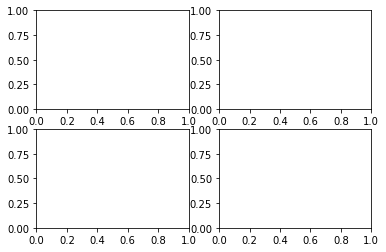

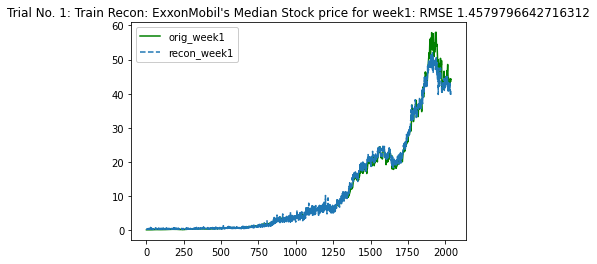

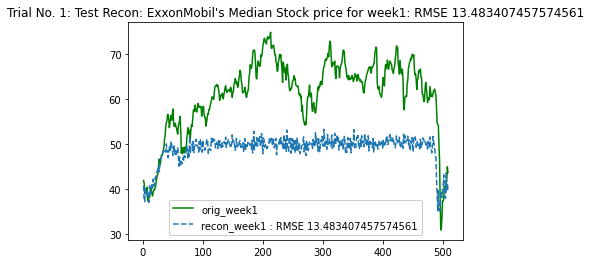

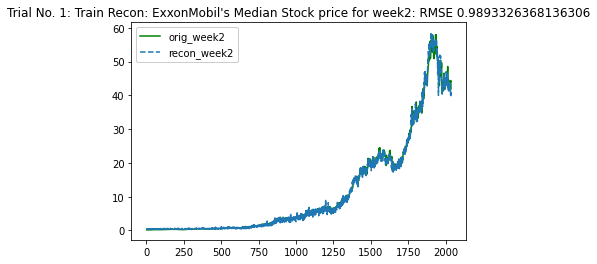

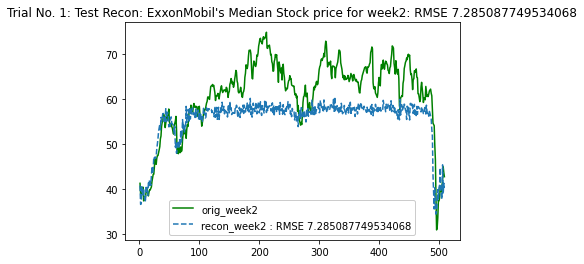

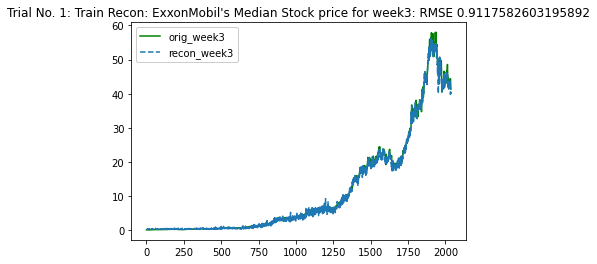

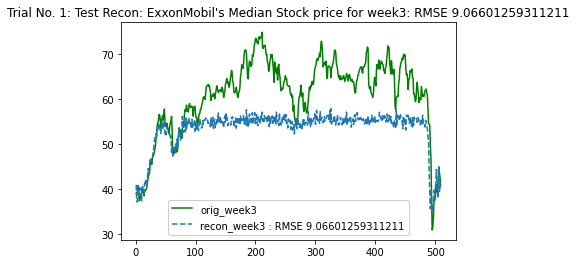

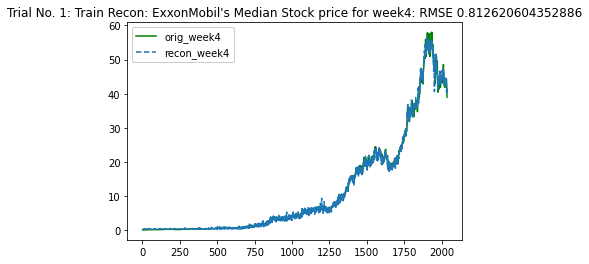

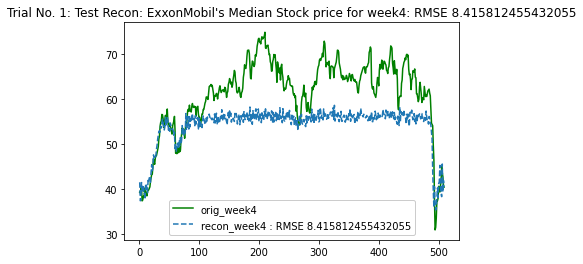

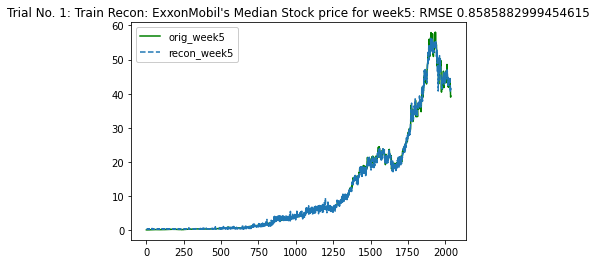

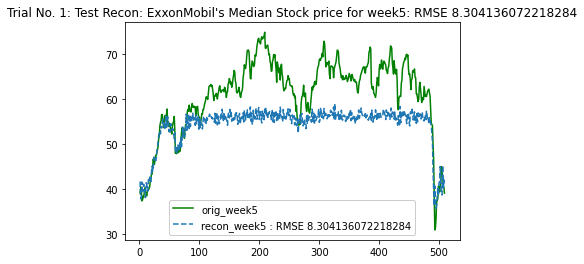

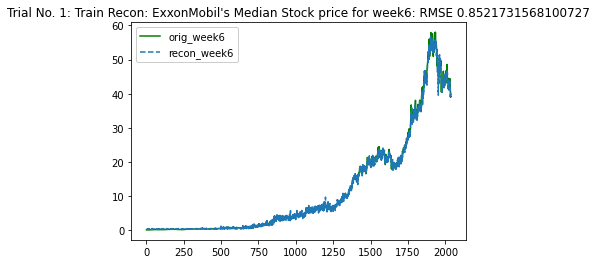

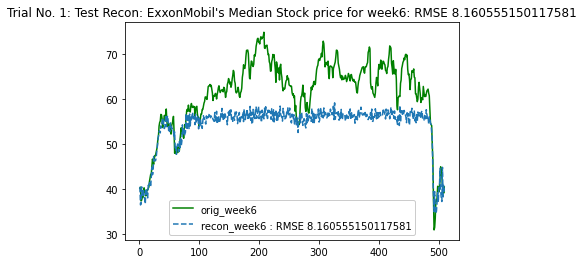

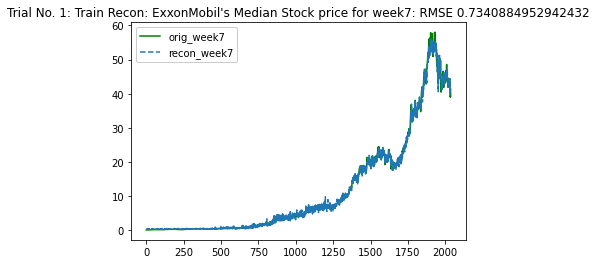

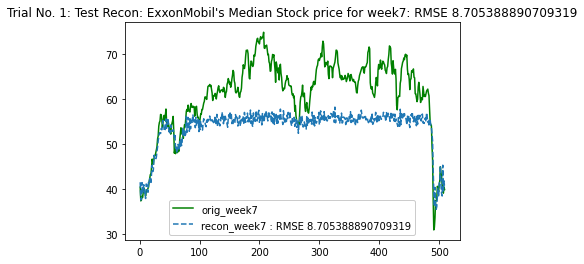

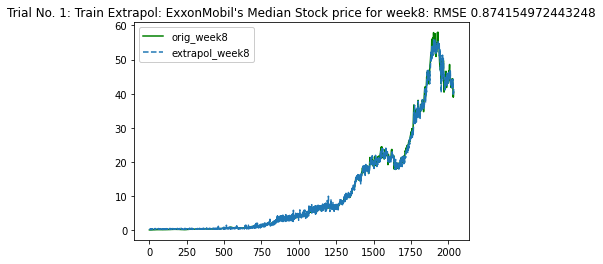

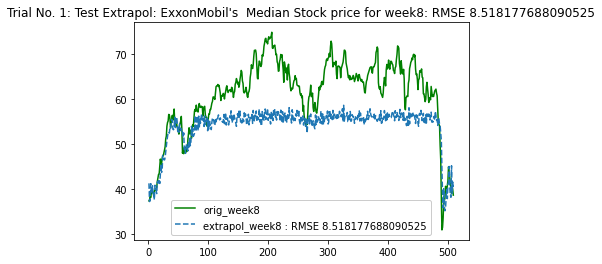

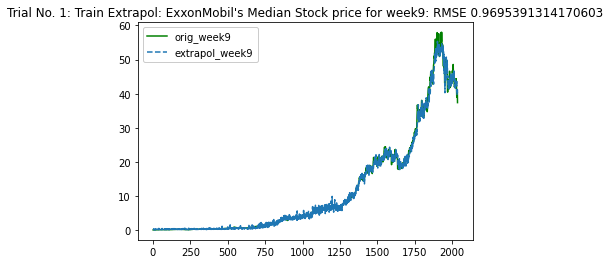

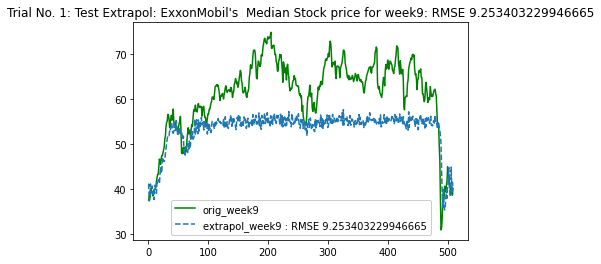

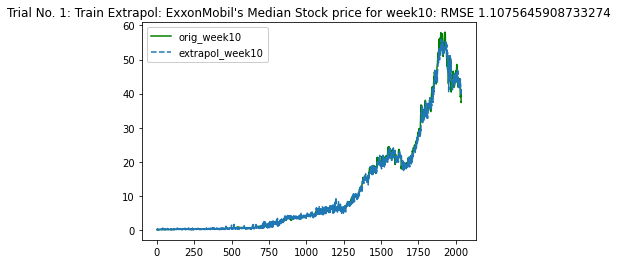

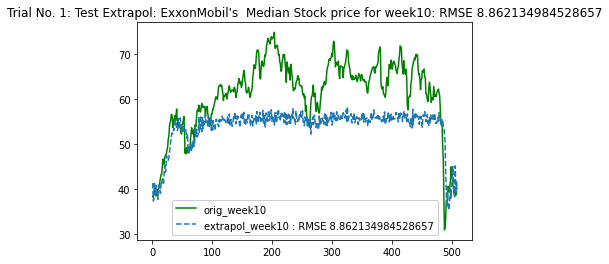

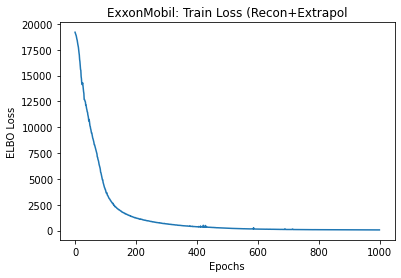

In [ ]:
# Plots
fig, axes = plt.subplots(2, 2)
for i in range(1, lag+forecast+1):
    if i<=lag:
        plot_train_recon(i, train_y_recon, pred_train_recon, fig, axes)
        plot_test_recon(i, test_y_recon, pred_test_recon, fig, axes)
    elif i>lag:
        plot_train_extrapol(i, train_y_extrapol, pred_train_extrapol, fig, axes)
        plot_test_extrapol(i, test_y_extrapol, pred_test_extrapol, fig, axes)
plot_loss(loss_list)

In [ ]:
# RMSE Table
recon_rmse_filepath = f"results-latentode/{tickerName}-trial{trial}-recon-rmse.csv"
extrapol_rmse_filepath = f"results-latentode/{tickerName}-trial{trial}-extrapol-rmse.csv"
recon_rmse_data, extrapol_rmse_data = rmse_table(recon_rmse_filepath, extrapol_rmse_filepath, train_y_recon, pred_train_recon, train_y_extrapol, pred_train_extrapol, test_y_recon, pred_test_recon, test_y_extrapol, pred_test_extrapol)

In [ ]:
tickerName = 'ExxonMobil'
trial = 1
pd.read_csv(f"results-latentode/{tickerName}-trial{trial}-recon-rmse.csv", index_col=0)

,week,train_recon_rmse,test_recon_rmse
0,1,1.457980,13.483407
1,2,0.989333,7.285088
2,3,0.911758,9.066013
3,4,0.812621,8.415812
4,5,0.858588,8.304136
5,6,0.852173,8.160555
6,7,0.734088,8.705389


In [ ]:
pd.read_csv(f"results-latentode/{tickerName}-trial{trial}-extrapol-rmse.csv", index_col=0)


,week,train_extrapol_rmse,test_extrapol_rmse
0,8,0.874155,8.518178
1,9,0.969539,9.253403
2,10,1.107565,8.862135


### ExxonMobil: Trial 2

In [ ]:
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd 
from pandas import concat
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
from torchdiffeq.torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dict_tickers = {
    'Apple': 'AAPL',
    'Microsoft': 'MSFT',
    'Google': 'GOOG',
    'Bitcoin': 'BTC-USD',
    'Facebook': 'FB',
    'Walmart': 'WMT',
    'Amazon': 'AMZN',
    'CVS': 'CVS',
    'Berkshire': 'BRK-B',
    'ExxonMobil': 'XOM',
    'AtandT': 'T',
    'Costco': 'COST',
    'Walgreens': 'WBA',
    'Kroger': 'KR',
    'JPMorgan': 'JPM',
    'Verizon': 'VZ',
    'FordMotor': 'F',
    'GeneralMotors': 'GM',
    'Dell': 'DELL',
    'BankOfAmerica': 'BAC',
    'Target': 'TGT',
    'GeneralElectric': 'GE',
    'JohnsonandJohnson': 'JNJ',
    'Nvidia': 'NVDA',
    'Intel': 'INTC',
}

def stockDataTransformer(filepath):
    df = pd.read_csv(filepath)
    df.set_index('Date', inplace=True)
    df1 = df[['Open', 'Close']].copy()
    data = df1.values
    n_samples = data.shape[0]//10*10
    reshape_number = n_samples*data.shape[1]//10
    data1 = data[:n_samples].reshape((reshape_number, 10))
    return data1

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def get_median(array, axis = 1):
    # https://numpy.org/doc/stable/reference/generated/numpy.median.html
    return np.median(array, axis = axis).reshape(data_size, 1)  #, keepdims=True)

def split_data(perc_train, perc_valid, lag, data_orig, data_m1, n_features_orig, n_features_median):
    values = data_m1
    
    sizeOfReframed = len(data_m1)
    len_train = int(perc_train*sizeOfReframed) # int(sizeOfReframed - len_test) # - len_valid)
    train_data_orig = data_orig[:len_train, :]
    # valid = values[len_train:len_valid+len_train, :]
    test_data_orig = data_orig[len_train:, :]  # [len_valid+len_train:, :]
    # n_features = n_features
    
    train_data_ml = values[:len_train, :]
    test_data_ml = values[len_train:, :] 
    # split into input and outputs
    n_obs = lag * n_features_orig
    n_obs_median = (lag+forecast) * n_features_median
    train_X, train_y = train_data_orig[:, :n_obs], train_data_ml[:, :n_obs_median]
    test_X, test_y = test_data_orig[:, :n_obs], test_data_ml[:, :n_obs_median]
    # valid_X, valid_y = valid[:, :n_obs], valid[:, -1]
    print(train_X.shape, len(train_X), train_y.shape)
    
    # reshape input to be 3D [samples, features, lag]
    train_X = train_X.reshape((train_X.shape[0], n_features_orig, lag))
    test_X = test_X.reshape((test_X.shape[0], n_features_orig, lag))
    # valid_X = valid_X.reshape((valid_X.shape[0], lag, n_features))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)  # , valid_X.shape, valid_y.shape)
    
    # Get the reconstruction train_y, test_y and extrapolated train_y, test_y
    train_y_recon, train_y_extrapol = train_y[:, :lag], train_y[:, lag:]
    test_y_recon, test_y_extrapol = test_y[:, :lag], test_y[:, lag:]
    dataload = {
        'train_data_orig': train_data_orig,
        'test_data_orig': test_data_orig,
        'train_data_ml': train_data_ml,
        'test_data_ml': test_data_ml,
        # 'valid': valid,
        'train_X': train_X,
        'train_y': train_y,
        'test_X': test_X,
        'test_y': test_y,
        'n_features_orig': n_features_orig,
        'n_features_median': n_features_median,
        'n_obs': n_obs,
        'n_obs_median': n_obs_median,
        # 'valid_X': valid_X,
        # 'valid_y': valid_y,
        'train_y_recon': train_y_recon,
        'train_y_extrapol': train_y_extrapol,
        'test_y_recon': test_y_recon,
        'test_y_extrapol': test_y_extrapol
    }
    
    return dataload

# https://discuss.pytorch.org/t/rmse-loss-function/16540/3
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss
class LatentODEfunc(nn.Module):

    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x).to(device)
        out = self.elu(out).to(device)
        out = self.fc2(out).to(device)
        out = self.elu(out).to(device)
        out = self.fc3(out).to(device)
        return out

class RecognitionRNN(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=5, nhidden=25, nbatch=1):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.i2h = self.i2h.float()
        self.h2o = nn.Linear(nhidden, latent_dim * 2)
        self.h2o = self.h2o.float()

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1).to(device)
        h = torch.tanh(self.i2h(combined.float())).to(device)
        out = self.h2o(h).to(device)
        return out, h

    def initHidden(self):
        return torch.zeros(self.nbatch, self.nhidden)

class Decoder(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=5, nhidden=20):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.fc1(z).to(device)
        out = self.relu(out).to(device)
        out = self.fc2(out).to(device)
        return out

class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float().to(x.device).to(device)
    const = torch.log(const).to(device)
    return -.5 * (const + logvar + (x - mean) ** 2. / torch.exp(logvar))

def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl.to(device)

def train(loss_str, niters):
    loss_list = []
    for itr in range(1, niters + 1):
    
        optimizer.zero_grad()
        # backward in time to infer q(z_0)
        h = rec.initHidden().to(device)  # (# nbatches_train, rnn_hidden)
        for t_r in reversed(range(train_X.shape[2])):  # input_dimension
            obs = train_X[:, :, t_r].to(device)
            # obs = torch.reshape(obs, (1, 1)).to(device)
            out, h = rec.forward(obs, h)
        qz0_mean, qz0_logvar = out[:, :latent_dim].to(device), out[:, latent_dim:].to(device)
        epsilon = torch.randn(qz0_mean.size()).to(device)
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

        # forward in time and solve ode for reconstructions
        pred_z = odeint(func, z0, t.to(device)).permute(1, 0, 2)  # [:, -1, :]
        pred_x = dec(pred_z).to(device)
        pred_x = torch.reshape(pred_x, (train_X.shape[0], lag+forecast)).to(device)

        # compute loss
        if loss_str == 'mse':
            loss = torch.nn.MSELoss()(pred_x.float(), train_X[i, :, :].float().to(device)).float()
        elif loss_str == 'elbo':
            noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
            noise_logvar = 2. * torch.log(noise_std_).to(device)
            logpx = log_normal_pdf(
                train_y[:, 0, :].to(device), pred_x, noise_logvar).sum(-1)  # .sum(-1)
            pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
            analytic_kl = normal_kl(qz0_mean, qz0_logvar,
                                    pz0_mean, pz0_logvar).sum(-1)
            loss = torch.mean(-logpx + analytic_kl, dim=0).to(device)
            # loss = torch.reshape(loss, (1, 1)).to(device)
        loss_list.append(loss)
            # loss_ = torch.mean(torch.cat([x.float() for x in loss_list])).to(device)  
        loss.backward()
        optimizer.step()
        # loss_meter.update(loss.item())
        if itr%10==0:
            print('Iter: {}, running: {:.4f}'.format(itr, loss.item()))
    return loss_list

def train_loss(h):
    train_loss = 0.0
    predictions = []
    
    for t_r in reversed(range(train_X.shape[2])):
        obs = train_X[:, :, t_r].to(device)
        # obs = torch.reshape(obs, (1, 1)).to(device)
        out, h = rec.forward(obs, h)

    qz0_mean, qz0_logvar = out[:, :latent_dim].to(device), out[:, latent_dim:].to(device)
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

    # forward in time and solve ode for reconstructions
    pred_z = odeint(func, z0, t.to(device)).permute(1, 0, 2)
    pred_x = dec(pred_z).to(device)
    pred_x = torch.reshape(pred_x, (pred_x.shape[0], 1, lag+forecast))
    pred_x_recon = pred_x[:, :, :lag]
    pred_x_extrapol = pred_x[:, :, lag:]
    rmse = RMSELoss()
    # loss = torch.nn.MSELoss()(pred_x, train_X[:, :, :].to(device))
    loss_recon = rmse(pred_x_recon, train_y_recon)
    loss_extrapol = rmse(pred_x_extrapol, train_y_extrapol)
    # train_loss += loss
    # predictions.append(pred_x)
    
    # train_loss = torch.sqrt(train_loss)
    # train_pred = torch.cat([x.float() for x in predictions])
    # train_pred = torch.reshape(train_pred, (train_pred.shape[0], 1, lag))
    with torch.no_grad():
        print('Train: Reconstruction Loss')
        print('Total Train Loss {:.6f}'.format(loss_recon.item()))
        print('Train: Extrapolation Loss')
        print('Total Train Extrapolation Loss {:.6f}'.format(loss_extrapol.item()))
    return pred_x, pred_x_recon, pred_x_extrapol

def test_loss(h, t_test):
    # print(h.shape)
    test_loss = 0.0
    predictions = []
    rmse = RMSELoss()
    for t_r in reversed(range(test_X.shape[2])):
        obs = test_X[:, :, t_r].to(device)
        # obs = torch.reshape(obs, (1, 1)).to(device)
        out, h = rec.forward(obs, h)
    qz0_mean, qz0_logvar = out[:, :latent_dim].to(device), out[:, latent_dim:].to(device)
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

    # forward in time and solve ode for reconstructions
    pred_z = odeint(func, z0, t_test).permute(1, 0, 2).to(device)
    pred_x = dec(pred_z).to(device)
    pred_x = torch.reshape(pred_x, (pred_x.shape[0], 1, lag+forecast))
    pred_x_recon = pred_x[:, :, :lag]
    pred_x_extrapol = pred_x[:, :, lag:]
    # pred_test_X = torch.reshape(pred_test_X, (pred_test_X.shape[0], pred_test_X.shape[1]))
    # pred_test_y = torch.reshape(pred_test_y, (1, pred_test_y.shape[0], 1, lag))
    # print(test_pred_y.shape)
    rmse = RMSELoss()
    # loss = torch.nn.MSELoss()(pred_x, train_X[i, :, :].to(device))
    loss_recon = rmse(pred_x_recon, test_y_recon)
    loss_extrapol = rmse(pred_x_extrapol, test_y_extrapol)

    # loss = torch.nn.MSELoss()(pred_x, torch.reshape(test_X[i, :, :].to(device), (1, 5))).to(device)
    # test_loss += loss
    # predictions.append(pred_x)
    
    # test_loss = torch.sqrt(test_loss)
    # test_pred = torch.cat([x.float() for x in predictions])
    
    # loss = torch.nn.MSELoss()(test_pred_y[train_size-test_size:, batch_time2-2, :], label_batch_y[train_size-test_size:, batch_time2-2, :])
    with torch.no_grad():
        print('Test: Reconstruction Loss')
        print('Total Loss {:.6f}'.format(loss_recon.item()))
        print('Test: Extrapolation Loss')
        print('Total Loss {:.6f}'.format(loss_extrapol.item()))
    return pred_x, pred_x_recon, pred_x_extrapol

def plot_train_recon(i, train_y_recon, pred_y_recon, fig, axes):
    t_ = torch.linspace(1., train_y_recon.shape[0], train_y_recon.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), train_y_recon.cpu().numpy()[:, :, i-1], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((train_y_recon.cpu().numpy()[:, :, i-1] - pred_y_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_recon.cpu().numpy()[:, :, i-1], '--', label = f"recon_week{i}")
    plt.title(f"Trial No. {trial}: Train Recon: {tickerName}'s Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Train Recon: {tickerName}'s Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_train_extrapol(i, train_y_extrapol, pred_y_extrapol, fig, axes):
    t_ = torch.linspace(1., train_y_extrapol.shape[0], train_y_extrapol.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), train_y_extrapol.cpu().numpy()[:, :, i-1-lag], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((train_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_y_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_extrapol.cpu().numpy()[:, :, i-1-lag], '--', label = f"extrapol_week{i}")
    plt.title(f"Trial No. {trial}: Train Extrapol: {tickerName}'s Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Train Extrapol: {tickerName}'s Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_test_recon(i, test_y_recon, pred_y_recon, fig, axes):
    t_ = torch.linspace(1., test_y_recon.shape[0], test_y_recon.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), test_y_recon.cpu().numpy()[:, :, i-1], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((test_y_recon.cpu().numpy()[:, :, i-1] - pred_y_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_recon.cpu().numpy()[:, :, i-1], '--', label = f"recon_week{i} : RMSE {rmse}")
    plt.title(f"Trial No. {trial}: Test Recon: {tickerName}'s Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Test Recon: {tickerName}'s Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_test_extrapol(i, test_y_extrapol, pred_y_extrapol, fig, axes):
    t_ = torch.linspace(1., test_y_extrapol.shape[0], test_y_extrapol.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), test_y_extrapol.cpu().numpy()[:, :, i-1-lag], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((test_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_y_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_extrapol.cpu().numpy()[:, :, i-1-lag], '--', label = f"extrapol_week{i} : RMSE {rmse}")
    plt.title(f"Trial No. {trial}: Test Extrapol: {tickerName}'s  Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Test Extrapol: {tickerName}'s  Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_loss(loss_list):
    plt.plot(loss_list)
    plt.title(f'{tickerName}: Train Loss (Recon+Extrapol')
    plt.ylabel('ELBO Loss')
    plt.xlabel('Epochs')
    plt.savefig(f"plots-latentode/{tickerName}: Trial No. {trial}: ELBO Train Loss.pdf", dpi = 150)
    plt.show()

def rmse_table(recon_rmse_filepath, extrapol_rmse_filepath, train_y_recon, pred_train_recon, train_y_extrapol, pred_train_extrapol, test_y_recon, pred_test_recon, test_y_extrapol, pred_test_extrapol):
    recon_rmse_data = {
        'week': list(),
        'train_recon_rmse': list(),
        'test_recon_rmse': list()
    }

    extrapol_rmse_data = {
        'week': list(),
        'train_extrapol_rmse': list(),
        'test_extrapol_rmse': list()
    }
    for i in range(1, lag+forecast+1):
        with torch.no_grad():
            if i<=lag:
                recon_rmse_data['week'].append(i)
                train_recon_rmse = np.sqrt(((train_y_recon.cpu().numpy()[:, :, i-1] - pred_train_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
                recon_rmse_data['train_recon_rmse'].append(train_recon_rmse)
                test_recon_rmse = np.sqrt(((test_y_recon.cpu().numpy()[:, :, i-1] - pred_test_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
                recon_rmse_data['test_recon_rmse'].append(test_recon_rmse)
            elif i>lag:
                extrapol_rmse_data['week'].append(i)
                train_extrapol_rmse = np.sqrt(((train_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_train_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
                extrapol_rmse_data['train_extrapol_rmse'].append(train_extrapol_rmse)
                test_extrapol_rmse = np.sqrt(((test_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_test_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
                extrapol_rmse_data['test_extrapol_rmse'].append(test_extrapol_rmse)
    recon_rmse_df = pd.DataFrame(recon_rmse_data)
    recon_rmse_df.to_csv(recon_rmse_filepath)
    extrapol_rmse_df = pd.DataFrame(extrapol_rmse_data)
    extrapol_rmse_df.to_csv(extrapol_rmse_filepath)

    return recon_rmse_data, extrapol_rmse_data


In [ ]:

# FileName
tickerName = 'ExxonMobil'
# Filepath
filepath = f"raw-stock-data/{tickerName}.csv"
# Get the data in the required format
data = stockDataTransformer(filepath)
print('Data after Data Transformation')
# # Total Data Size
data_size = data.shape[0]

print(pd.DataFrame(data))
print('\n')

lag = 7
forecast = 3
data_orig = series_to_supervised(data, lag, forecast).values
print('Data Original after series to supervised on data')
print(data_orig.shape)
print(pd.DataFrame(data_orig))
print('\n')

median_data = get_median(data)
print('Median data')
# Median data for each week
print(median_data.shape)
print(pd.DataFrame(median_data, columns = ['median_stockprice_week']).head(10))
print('\n')

# Convert median_data to (n_samples, 5) matrix
data_m1 = series_to_supervised(median_data, lag, forecast).values
print('Median data after series to supervised')
print(data_m1.shape)
print(pd.DataFrame(data_m1, columns = [f"week i+{i}" for i in range(1, lag+forecast+1)]))
print('\n')

dataload = split_data(0.8, 0, lag, data_orig, data_m1, data.shape[1], 1)

print('Get Train and Test data')
train_X = torch.from_numpy(dataload['train_X']).to(device)
print(f"train_X shape: {train_X.shape}")  # (#training, 1, 5)

train_y = torch.from_numpy(dataload['train_y']).to(device)
print(f"train_y shape: {train_y.shape}")  # (#training, 5)
train_y = torch.reshape(train_y, (train_X.shape[0], 1, train_y.shape[1])).to(device)
print(f"train_y shape: {train_y.shape}")  # (#training, 1, 5)
test_X = torch.from_numpy(dataload['test_X']).to(device)
print(f"test_X.shape : {test_X.shape}")  # (#testing, 1, 5)
test_y = torch.from_numpy(dataload['test_y']).to(device)
print(f"test_y.shape : {test_y.shape}")  # (#testing, 5)
test_y = torch.reshape(test_y, (test_X.shape[0], 1, test_y.shape[1])).to(device)
print(f"test_y.shape : {test_y.shape}")

train_y_recon = torch.from_numpy(dataload['train_y_recon']).to(device)
train_y_recon = torch.reshape(train_y_recon, (train_y_recon.shape[0], 1,train_y_recon.shape[1]))
train_y_extrapol = torch.from_numpy(dataload['train_y_extrapol']).to(device)
train_y_extrapol = torch.reshape(train_y_extrapol, (train_y_extrapol.shape[0], 1, train_y_extrapol.shape[1]))
test_y_recon = torch.from_numpy(dataload['test_y_recon']).to(device)
test_y_recon = torch.reshape(test_y_recon, (test_y_recon.shape[0], 1, test_y_recon.shape[1]))
test_y_extrapol = torch.from_numpy(dataload['test_y_extrapol']).to(device)
test_y_extrapol = torch.reshape(test_y_extrapol, (test_y_extrapol.shape[0], 1, test_y_extrapol.shape[1]))
print(f"train_y_recon.shape : {train_y_recon.shape}")
print(f"train_y_extrapol.shape : {train_y_extrapol.shape}")
print(f"test_y_recon.shape : {test_y_recon.shape}")
print(f"test_y_extrapol.shape : {test_y_extrapol.shape}")
print('\n')

trial = 2
# predictions on test_data's time size (test_size-batch_time, 1)
# Time steps
t = torch.linspace(0, lag+forecast-1, lag+forecast).to(device)
print(f"t.shape : {t.shape}")

latent_dim = 50
nhidden = 100
rnn_nhidden = 125
obs_dim = data.shape[1]
out_dim = 1
noise_std = .3

lr = 0.001
loss_str = 'elbo'
# all_values = True
niters = 2000  # training epochs

Data after Data Transformation
              0          1          2  ...          7          8          9
0      0.178288   0.179010   0.179010  ...   0.180453   0.180453   0.180814
1      0.180814   0.181536   0.181536  ...   0.179731   0.179731   0.177927
2      0.177927   0.178649   0.178649  ...   0.177566   0.177566   0.176483
3      0.176483   0.173957   0.173957  ...   0.167821   0.166378   0.164212
4      0.163852   0.162769   0.162769  ...   0.164573   0.164573   0.164212
...         ...        ...        ...  ...        ...        ...        ...
2549  41.166637  40.800957  40.508416  ...  38.853703  39.447934  40.819241
2550  40.362144  39.868473  39.676488  ...  40.289005  40.142736  39.813622
2551  39.959889  40.252434  39.429652  ...  38.625149  38.707430  39.740482
2552  40.362140  40.087875  39.676486  ...  40.691257  41.596317  41.111790
2553  41.447394  41.102467  40.552445  ...  39.750713  39.704109  39.554951

[2554 rows x 10 columns]


Data Original after series to

In [ ]:
## Training
# model
nbatches_train = train_X.shape[0]
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nbatches_train).to(device)
dec = Decoder(latent_dim, out_dim, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
optimizer = optim.Adam(params, lr=lr)
loss_list = train(loss_str, niters)

# https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_models_for_inference.html
torch.save(func.state_dict(), f"model-latentode/{tickerName}-trial{trial}-func-moresequences.pth")
torch.save(rec.state_dict(), f"model-latentode/{tickerName}-trial{trial}-rec-moresequences.pth")
torch.save(dec.state_dict(), f"model-latentode/{tickerName}-trial{trial}-dec-moresequences.pth")

func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nbatches_train).to(device)
dec = Decoder(latent_dim, out_dim, nhidden).to(device)

func.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-func-moresequences.pth"))  # f"model-latentode/{tickerName}-trial{trial}-func-moresequences.pth"
rec.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-rec-moresequences.pth"))  # f"model-latentode/{tickerName}-trial{trial}-rec-moresequences.pth"
dec.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-dec-moresequences.pth"))  # f"model-latentode/{tickerName}-trial{trial}-dec-moresequences.pth"

h = rec.initHidden().to(device)
pred_train, pred_train_recon, pred_train_extrapol = train_loss(h)

# Testing
# model

nbatches_test = test_X.shape[0]
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nbatches_test).to(device)
dec = Decoder(latent_dim, out_dim, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))

func.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-func-moresequences.pth"))
rec.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-rec-moresequences.pth"))
dec.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-dec-moresequences.pth")) 

h = rec.initHidden().to(device)
pred_test, pred_test_recon, pred_test_extrapol = test_loss(h, t)


Iter: 10, running: 12411.2327
Iter: 20, running: 7509.3629
Iter: 30, running: 3145.6827
Iter: 40, running: 1603.1929
Iter: 50, running: 875.5191
Iter: 60, running: 625.8344
Iter: 70, running: 469.3642
Iter: 80, running: 368.6505
Iter: 90, running: 304.0493
Iter: 100, running: 255.8243
Iter: 110, running: 227.8576
Iter: 120, running: 206.7647
Iter: 130, running: 188.3101
Iter: 140, running: 177.7989
Iter: 150, running: 176.5878
Iter: 160, running: 163.0638
Iter: 170, running: 158.7279
Iter: 180, running: 162.2638
Iter: 190, running: 148.8014
Iter: 200, running: 143.3408
Iter: 210, running: 142.8344
Iter: 220, running: 135.2908
Iter: 230, running: 134.6987
Iter: 240, running: 131.8246
Iter: 250, running: 147.2886
Iter: 260, running: 134.6475
Iter: 270, running: 126.8722
Iter: 280, running: 121.1179
Iter: 290, running: 120.2724
Iter: 300, running: 202.3651
Iter: 310, running: 139.4750
Iter: 320, running: 129.4647
Iter: 330, running: 116.9463
Iter: 340, running: 113.1438
Iter: 350, running

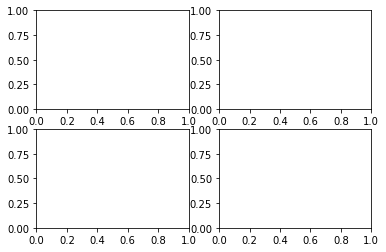

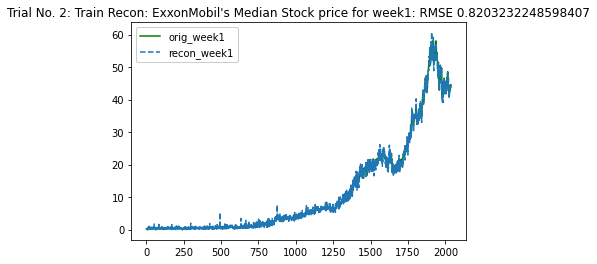

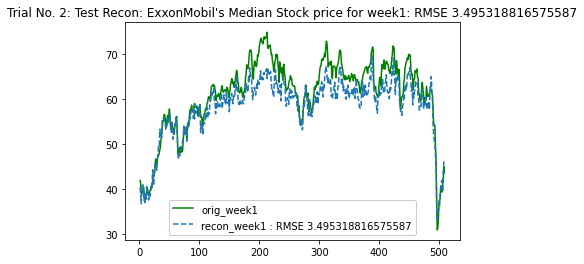

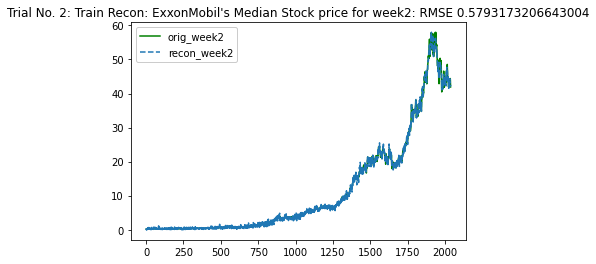

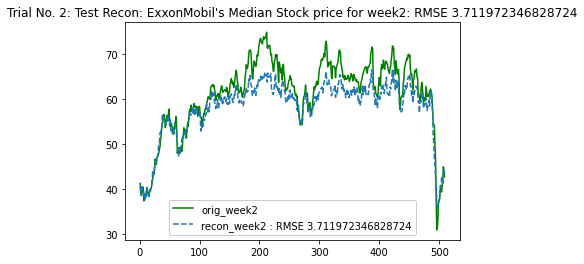

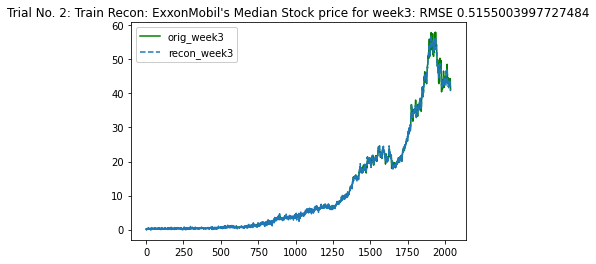

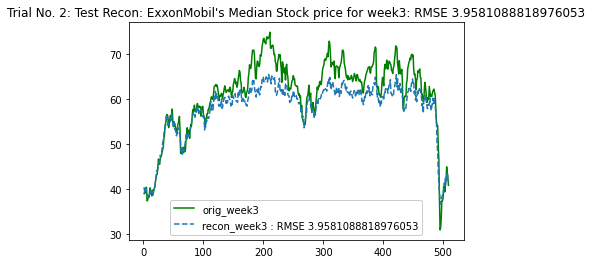

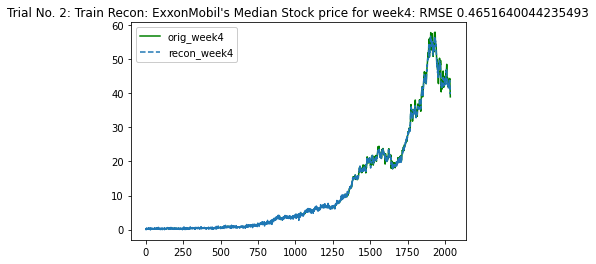

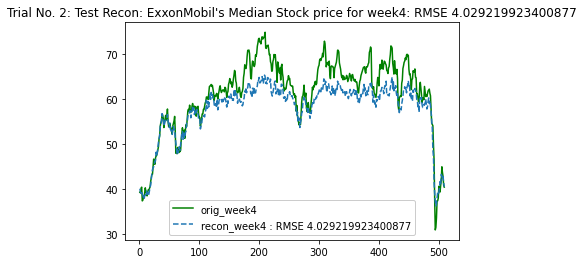

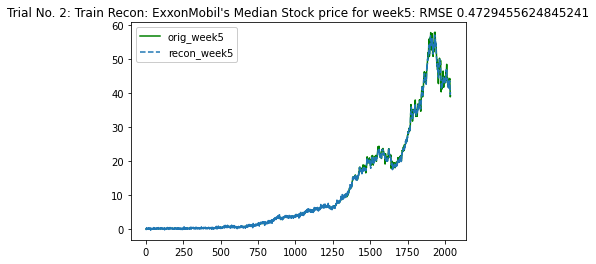

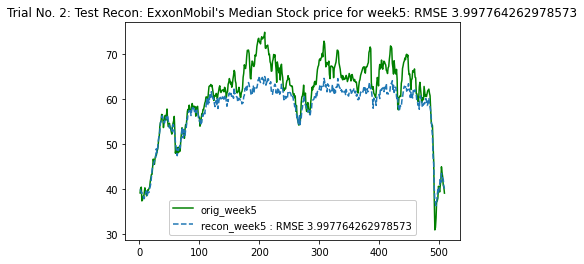

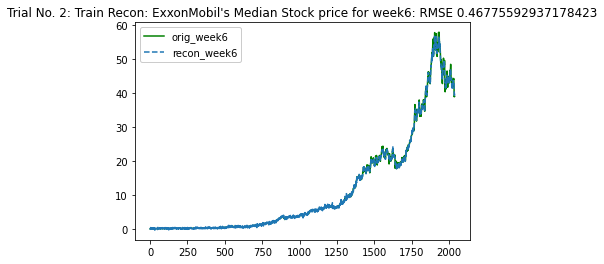

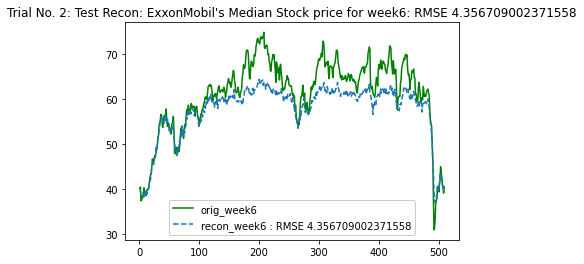

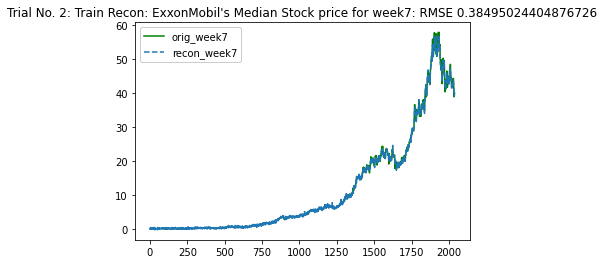

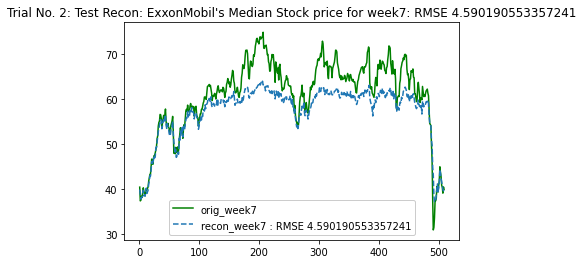

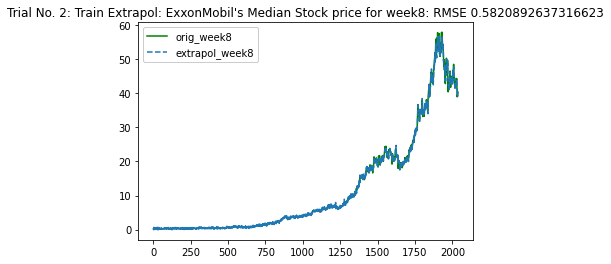

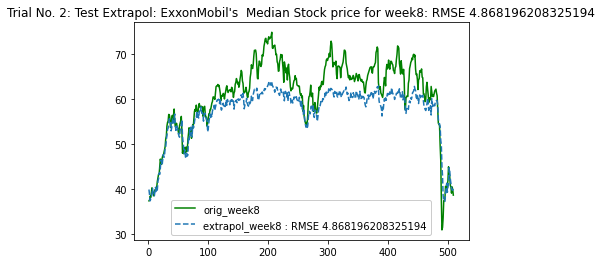

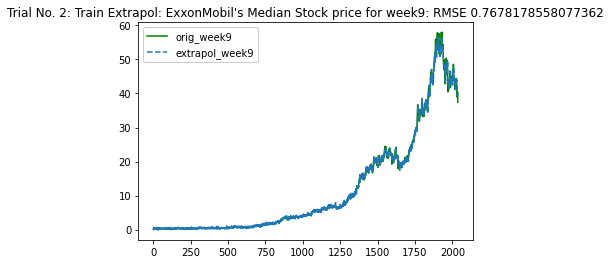

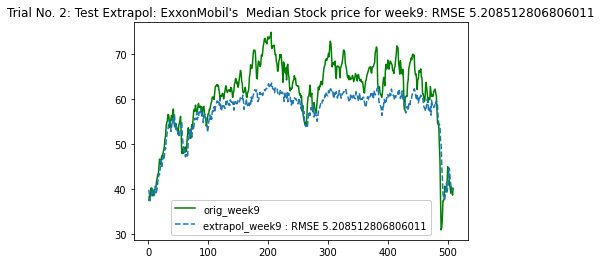

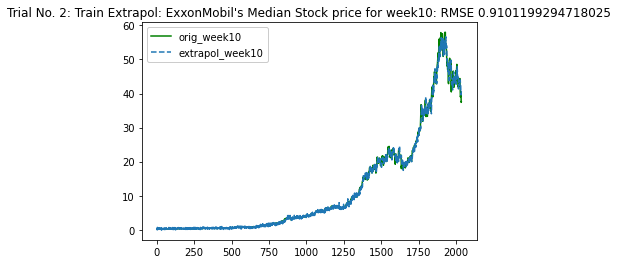

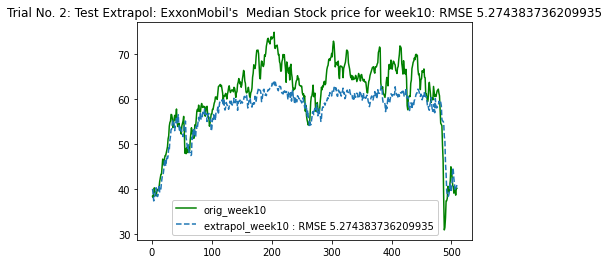

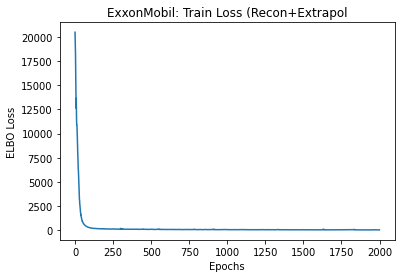

In [ ]:
# Plots
fig, axes = plt.subplots(2, 2)
for i in range(1, lag+forecast+1):
    if i<=lag:
        plot_train_recon(i, train_y_recon, pred_train_recon, fig, axes)
        plot_test_recon(i, test_y_recon, pred_test_recon, fig, axes)
    elif i>lag:
        plot_train_extrapol(i, train_y_extrapol, pred_train_extrapol, fig, axes)
        plot_test_extrapol(i, test_y_extrapol, pred_test_extrapol, fig, axes)
plot_loss(loss_list)

In [ ]:
# RMSE Table
recon_rmse_filepath = f"results-latentode/{tickerName}-trial{trial}-recon-rmse.csv"
extrapol_rmse_filepath = f"results-latentode/{tickerName}-trial{trial}-extrapol-rmse.csv"
recon_rmse_data, extrapol_rmse_data = rmse_table(recon_rmse_filepath, extrapol_rmse_filepath, train_y_recon, pred_train_recon, train_y_extrapol, pred_train_extrapol, test_y_recon, pred_test_recon, test_y_extrapol, pred_test_extrapol)

pd.read_csv(f"results-latentode/{tickerName}-trial{trial}-recon-rmse.csv", index_col=0)

,week,train_recon_rmse,test_recon_rmse
0,1,0.820323,3.495319
1,2,0.579317,3.711972
2,3,0.515500,3.958109
3,4,0.465164,4.029220
4,5,0.472946,3.997764
5,6,0.467756,4.356709
6,7,0.384950,4.590191


In [ ]:
pd.read_csv(f"results-latentode/{tickerName}-trial{trial}-extrapol-rmse.csv", index_col=0)

,week,train_extrapol_rmse,test_extrapol_rmse
0,8,0.582089,4.868196
1,9,0.767818,5.208513
2,10,0.910120,5.274384


### ExxonMobil: Trial 3

In [5]:
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd 
from pandas import concat
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
from torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dict_tickers = {
    'Apple': 'AAPL',
    'Microsoft': 'MSFT',
    'Google': 'GOOG',
    'Bitcoin': 'BTC-USD',
    'Facebook': 'FB',
    'Walmart': 'WMT',
    'Amazon': 'AMZN',
    'CVS': 'CVS',
    'Berkshire': 'BRK-B',
    'ExxonMobil': 'XOM',
    'AtandT': 'T',
    'Costco': 'COST',
    'Walgreens': 'WBA',
    'Kroger': 'KR',
    'JPMorgan': 'JPM',
    'Verizon': 'VZ',
    'FordMotor': 'F',
    'GeneralMotors': 'GM',
    'Dell': 'DELL',
    'BankOfAmerica': 'BAC',
    'Target': 'TGT',
    'GeneralElectric': 'GE',
    'JohnsonandJohnson': 'JNJ',
    'Nvidia': 'NVDA',
    'Intel': 'INTC',
}

def stockDataTransformer(filepath):
    df = pd.read_csv(filepath)
    df.set_index('Date', inplace=True)
    df1 = df[['Open', 'Close']].copy()
    data = df1.values
    n_samples = data.shape[0]//10*10
    reshape_number = n_samples*data.shape[1]//10
    data1 = data[:n_samples].reshape((reshape_number, 10))
    return data1

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def get_median(array, axis = 1):
    # https://numpy.org/doc/stable/reference/generated/numpy.median.html
    return np.median(array, axis = axis).reshape(data_size, 1)  #, keepdims=True)

def split_data(perc_train, perc_valid, lag, data_orig, data_m1, n_features_orig, n_features_median):
    values = data_m1
    
    sizeOfReframed = len(data_m1)
    len_train = int(perc_train*sizeOfReframed) # int(sizeOfReframed - len_test) # - len_valid)
    train_data_orig = data_orig[:len_train, :]
    # valid = values[len_train:len_valid+len_train, :]
    test_data_orig = data_orig[len_train:, :]  # [len_valid+len_train:, :]
    # n_features = n_features
    
    train_data_ml = values[:len_train, :]
    test_data_ml = values[len_train:, :] 
    # split into input and outputs
    n_obs = lag * n_features_orig
    n_obs_median = (lag+forecast) * n_features_median
    train_X, train_y = train_data_orig[:, :n_obs], train_data_ml[:, :n_obs_median]
    test_X, test_y = test_data_orig[:, :n_obs], test_data_ml[:, :n_obs_median]
    # valid_X, valid_y = valid[:, :n_obs], valid[:, -1]
    print(train_X.shape, len(train_X), train_y.shape)
    
    # reshape input to be 3D [samples, features, lag]
    train_X = train_X.reshape((train_X.shape[0], n_features_orig, lag))
    test_X = test_X.reshape((test_X.shape[0], n_features_orig, lag))
    # valid_X = valid_X.reshape((valid_X.shape[0], lag, n_features))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)  # , valid_X.shape, valid_y.shape)
    
    # Get the reconstruction train_y, test_y and extrapolated train_y, test_y
    train_y_recon, train_y_extrapol = train_y[:, :lag], train_y[:, lag:]
    test_y_recon, test_y_extrapol = test_y[:, :lag], test_y[:, lag:]
    dataload = {
        'train_data_orig': train_data_orig,
        'test_data_orig': test_data_orig,
        'train_data_ml': train_data_ml,
        'test_data_ml': test_data_ml,
        # 'valid': valid,
        'train_X': train_X,
        'train_y': train_y,
        'test_X': test_X,
        'test_y': test_y,
        'n_features_orig': n_features_orig,
        'n_features_median': n_features_median,
        'n_obs': n_obs,
        'n_obs_median': n_obs_median,
        # 'valid_X': valid_X,
        # 'valid_y': valid_y,
        'train_y_recon': train_y_recon,
        'train_y_extrapol': train_y_extrapol,
        'test_y_recon': test_y_recon,
        'test_y_extrapol': test_y_extrapol
    }
    
    return dataload

# https://discuss.pytorch.org/t/rmse-loss-function/16540/3
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss
class LatentODEfunc(nn.Module):

    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x).to(device)
        out = self.elu(out).to(device)
        out = self.fc2(out).to(device)
        out = self.elu(out).to(device)
        out = self.fc3(out).to(device)
        return out

class RecognitionRNN(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=5, nhidden=25, nbatch=1):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.i2h = self.i2h.float()
        self.h2o = nn.Linear(nhidden, latent_dim * 2)
        self.h2o = self.h2o.float()

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1).to(device)
        h = torch.tanh(self.i2h(combined.float())).to(device)
        out = self.h2o(h).to(device)
        return out, h

    def initHidden(self):
        return torch.zeros(self.nbatch, self.nhidden)

class Decoder(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=5, nhidden=20):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.fc1(z).to(device)
        out = self.relu(out).to(device)
        out = self.fc2(out).to(device)
        return out

class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float().to(x.device).to(device)
    const = torch.log(const).to(device)
    return -.5 * (const + logvar + (x - mean) ** 2. / torch.exp(logvar))

def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl.to(device)

def train(loss_str, niters):
    loss_list = []
    for itr in range(1, niters + 1):
    
        optimizer.zero_grad()
        # backward in time to infer q(z_0)
        h = rec.initHidden().to(device)  # (# nbatches_train, rnn_hidden)
        for t_r in reversed(range(train_X.shape[2])):  # input_dimension
            obs = train_X[:, :, t_r].to(device)
            # obs = torch.reshape(obs, (1, 1)).to(device)
            out, h = rec.forward(obs, h)
        qz0_mean, qz0_logvar = out[:, :latent_dim].to(device), out[:, latent_dim:].to(device)
        epsilon = torch.randn(qz0_mean.size()).to(device)
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

        # forward in time and solve ode for reconstructions
        pred_z = odeint(func, z0, t.to(device)).permute(1, 0, 2)  # [:, -1, :]
        pred_x = dec(pred_z).to(device)
        pred_x = torch.reshape(pred_x, (train_X.shape[0], lag+forecast)).to(device)

        # compute loss
        if loss_str == 'mse':
            loss = torch.nn.MSELoss()(pred_x.float(), train_X[i, :, :].float().to(device)).float()
        elif loss_str == 'elbo':
            noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
            noise_logvar = 2. * torch.log(noise_std_).to(device)
            logpx = log_normal_pdf(
                train_y[:, 0, :].to(device), pred_x, noise_logvar).sum(-1)  # .sum(-1)
            pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
            analytic_kl = normal_kl(qz0_mean, qz0_logvar,
                                    pz0_mean, pz0_logvar).sum(-1)
            loss = torch.mean(-logpx + analytic_kl, dim=0).to(device)
            # loss = torch.reshape(loss, (1, 1)).to(device)
        loss_list.append(loss)
            # loss_ = torch.mean(torch.cat([x.float() for x in loss_list])).to(device)  
        loss.backward()
        optimizer.step()
        # loss_meter.update(loss.item())
        if itr%10==0:
            print('Iter: {}, running: {:.4f}'.format(itr, loss.item()))
    return loss_list

def train_loss(h):
    train_loss = 0.0
    predictions = []
    
    for t_r in reversed(range(train_X.shape[2])):
        obs = train_X[:, :, t_r].to(device)
        # obs = torch.reshape(obs, (1, 1)).to(device)
        out, h = rec.forward(obs, h)

    qz0_mean, qz0_logvar = out[:, :latent_dim].to(device), out[:, latent_dim:].to(device)
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

    # forward in time and solve ode for reconstructions
    pred_z = odeint(func, z0, t.to(device)).permute(1, 0, 2)
    pred_x = dec(pred_z).to(device)
    pred_x = torch.reshape(pred_x, (pred_x.shape[0], 1, lag+forecast))
    pred_x_recon = pred_x[:, :, :lag]
    pred_x_extrapol = pred_x[:, :, lag:]
    rmse = RMSELoss()
    # loss = torch.nn.MSELoss()(pred_x, train_X[:, :, :].to(device))
    loss_recon = rmse(pred_x_recon, train_y_recon)
    loss_extrapol = rmse(pred_x_extrapol, train_y_extrapol)
    # train_loss += loss
    # predictions.append(pred_x)
    
    # train_loss = torch.sqrt(train_loss)
    # train_pred = torch.cat([x.float() for x in predictions])
    # train_pred = torch.reshape(train_pred, (train_pred.shape[0], 1, lag))
    with torch.no_grad():
        print('Train: Reconstruction Loss')
        print('Total Train Loss {:.6f}'.format(loss_recon.item()))
        print('Train: Extrapolation Loss')
        print('Total Train Extrapolation Loss {:.6f}'.format(loss_extrapol.item()))
    return pred_x, pred_x_recon, pred_x_extrapol

def test_loss(h, t_test):
    # print(h.shape)
    test_loss = 0.0
    predictions = []
    rmse = RMSELoss()
    for t_r in reversed(range(test_X.shape[2])):
        obs = test_X[:, :, t_r].to(device)
        # obs = torch.reshape(obs, (1, 1)).to(device)
        out, h = rec.forward(obs, h)
    qz0_mean, qz0_logvar = out[:, :latent_dim].to(device), out[:, latent_dim:].to(device)
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

    # forward in time and solve ode for reconstructions
    pred_z = odeint(func, z0, t_test).permute(1, 0, 2).to(device)
    pred_x = dec(pred_z).to(device)
    pred_x = torch.reshape(pred_x, (pred_x.shape[0], 1, lag+forecast))
    pred_x_recon = pred_x[:, :, :lag]
    pred_x_extrapol = pred_x[:, :, lag:]
    # pred_test_X = torch.reshape(pred_test_X, (pred_test_X.shape[0], pred_test_X.shape[1]))
    # pred_test_y = torch.reshape(pred_test_y, (1, pred_test_y.shape[0], 1, lag))
    # print(test_pred_y.shape)
    rmse = RMSELoss()
    # loss = torch.nn.MSELoss()(pred_x, train_X[i, :, :].to(device))
    loss_recon = rmse(pred_x_recon, test_y_recon)
    loss_extrapol = rmse(pred_x_extrapol, test_y_extrapol)

    # loss = torch.nn.MSELoss()(pred_x, torch.reshape(test_X[i, :, :].to(device), (1, 5))).to(device)
    # test_loss += loss
    # predictions.append(pred_x)
    
    # test_loss = torch.sqrt(test_loss)
    # test_pred = torch.cat([x.float() for x in predictions])
    
    # loss = torch.nn.MSELoss()(test_pred_y[train_size-test_size:, batch_time2-2, :], label_batch_y[train_size-test_size:, batch_time2-2, :])
    with torch.no_grad():
        print('Test: Reconstruction Loss')
        print('Total Loss {:.6f}'.format(loss_recon.item()))
        print('Test: Extrapolation Loss')
        print('Total Loss {:.6f}'.format(loss_extrapol.item()))
    return pred_x, pred_x_recon, pred_x_extrapol

def plot_train_recon(i, train_y_recon, pred_y_recon, fig, axes):
    t_ = torch.linspace(1., train_y_recon.shape[0], train_y_recon.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), train_y_recon.cpu().numpy()[:, :, i-1], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((train_y_recon.cpu().numpy()[:, :, i-1] - pred_y_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_recon.cpu().numpy()[:, :, i-1], '--', label = f"recon_week{i}")
    plt.title(f"Trial No. {trial}: Train Recon: {tickerName}'s Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Train Recon: {tickerName}'s Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_train_extrapol(i, train_y_extrapol, pred_y_extrapol, fig, axes):
    t_ = torch.linspace(1., train_y_extrapol.shape[0], train_y_extrapol.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), train_y_extrapol.cpu().numpy()[:, :, i-1-lag], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((train_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_y_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_extrapol.cpu().numpy()[:, :, i-1-lag], '--', label = f"extrapol_week{i}")
    plt.title(f"Trial No. {trial}: Train Extrapol: {tickerName}'s Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Train Extrapol: {tickerName}'s Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_test_recon(i, test_y_recon, pred_y_recon, fig, axes):
    t_ = torch.linspace(1., test_y_recon.shape[0], test_y_recon.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), test_y_recon.cpu().numpy()[:, :, i-1], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((test_y_recon.cpu().numpy()[:, :, i-1] - pred_y_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_recon.cpu().numpy()[:, :, i-1], '--', label = f"recon_week{i} : RMSE {rmse}")
    plt.title(f"Trial No. {trial}: Test Recon: {tickerName}'s Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Test Recon: {tickerName}'s Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_test_extrapol(i, test_y_extrapol, pred_y_extrapol, fig, axes):
    t_ = torch.linspace(1., test_y_extrapol.shape[0], test_y_extrapol.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), test_y_extrapol.cpu().numpy()[:, :, i-1-lag], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((test_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_y_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_extrapol.cpu().numpy()[:, :, i-1-lag], '--', label = f"extrapol_week{i} : RMSE {rmse}")
    plt.title(f"Trial No. {trial}: Test Extrapol: {tickerName}'s  Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Test Extrapol: {tickerName}'s  Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_loss(loss_list):
    plt.plot(loss_list)
    plt.title(f'{tickerName}: Train Loss (Recon+Extrapol')
    plt.ylabel('ELBO Loss')
    plt.xlabel('Epochs')
    plt.savefig(f"plots-latentode/{tickerName}: Trial No. {trial}: ELBO Train Loss.pdf", dpi = 150)
    plt.show()

def rmse_table(recon_rmse_filepath, extrapol_rmse_filepath, train_y_recon, pred_train_recon, train_y_extrapol, pred_train_extrapol, test_y_recon, pred_test_recon, test_y_extrapol, pred_test_extrapol):
    recon_rmse_data = {
        'week': list(),
        'train_recon_rmse': list(),
        'test_recon_rmse': list()
    }

    extrapol_rmse_data = {
        'week': list(),
        'train_extrapol_rmse': list(),
        'test_extrapol_rmse': list()
    }
    for i in range(1, lag+forecast+1):
        with torch.no_grad():
            if i<=lag:
                recon_rmse_data['week'].append(i)
                train_recon_rmse = np.sqrt(((train_y_recon.cpu().numpy()[:, :, i-1] - pred_train_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
                recon_rmse_data['train_recon_rmse'].append(train_recon_rmse)
                test_recon_rmse = np.sqrt(((test_y_recon.cpu().numpy()[:, :, i-1] - pred_test_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
                recon_rmse_data['test_recon_rmse'].append(test_recon_rmse)
            elif i>lag:
                extrapol_rmse_data['week'].append(i)
                train_extrapol_rmse = np.sqrt(((train_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_train_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
                extrapol_rmse_data['train_extrapol_rmse'].append(train_extrapol_rmse)
                test_extrapol_rmse = np.sqrt(((test_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_test_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
                extrapol_rmse_data['test_extrapol_rmse'].append(test_extrapol_rmse)
    recon_rmse_df = pd.DataFrame(recon_rmse_data)
    recon_rmse_df.to_csv(recon_rmse_filepath)
    extrapol_rmse_df = pd.DataFrame(extrapol_rmse_data)
    extrapol_rmse_df.to_csv(extrapol_rmse_filepath)

    return recon_rmse_data, extrapol_rmse_data


In [6]:

# FileName
tickerName = 'ExxonMobil'
# Filepath
filepath = f"raw-stock-data/{tickerName}.csv"
# Get the data in the required format
data = stockDataTransformer(filepath)
print('Data after Data Transformation')
# # Total Data Size
data_size = data.shape[0]

print(pd.DataFrame(data))
print('\n')

lag = 7
forecast = 3
data_orig = series_to_supervised(data, lag, forecast).values
print('Data Original after series to supervised on data')
print(data_orig.shape)
print(pd.DataFrame(data_orig))
print('\n')

median_data = get_median(data)
print('Median data')
# Median data for each week
print(median_data.shape)
print(pd.DataFrame(median_data, columns = ['median_stockprice_week']).head(10))
print('\n')

# Convert median_data to (n_samples, 5) matrix
data_m1 = series_to_supervised(median_data, lag, forecast).values
print('Median data after series to supervised')
print(data_m1.shape)
print(pd.DataFrame(data_m1, columns = [f"week i+{i}" for i in range(1, lag+forecast+1)]))
print('\n')

dataload = split_data(0.8, 0, lag, data_orig, data_m1, data.shape[1], 1)

print('Get Train and Test data')
train_X = torch.from_numpy(dataload['train_X']).to(device)
print(f"train_X shape: {train_X.shape}")  # (#training, 1, 5)

train_y = torch.from_numpy(dataload['train_y']).to(device)
print(f"train_y shape: {train_y.shape}")  # (#training, 5)
train_y = torch.reshape(train_y, (train_X.shape[0], 1, train_y.shape[1])).to(device)
print(f"train_y shape: {train_y.shape}")  # (#training, 1, 5)
test_X = torch.from_numpy(dataload['test_X']).to(device)
print(f"test_X.shape : {test_X.shape}")  # (#testing, 1, 5)
test_y = torch.from_numpy(dataload['test_y']).to(device)
print(f"test_y.shape : {test_y.shape}")  # (#testing, 5)
test_y = torch.reshape(test_y, (test_X.shape[0], 1, test_y.shape[1])).to(device)
print(f"test_y.shape : {test_y.shape}")

train_y_recon = torch.from_numpy(dataload['train_y_recon']).to(device)
train_y_recon = torch.reshape(train_y_recon, (train_y_recon.shape[0], 1,train_y_recon.shape[1]))
train_y_extrapol = torch.from_numpy(dataload['train_y_extrapol']).to(device)
train_y_extrapol = torch.reshape(train_y_extrapol, (train_y_extrapol.shape[0], 1, train_y_extrapol.shape[1]))
test_y_recon = torch.from_numpy(dataload['test_y_recon']).to(device)
test_y_recon = torch.reshape(test_y_recon, (test_y_recon.shape[0], 1, test_y_recon.shape[1]))
test_y_extrapol = torch.from_numpy(dataload['test_y_extrapol']).to(device)
test_y_extrapol = torch.reshape(test_y_extrapol, (test_y_extrapol.shape[0], 1, test_y_extrapol.shape[1]))
print(f"train_y_recon.shape : {train_y_recon.shape}")
print(f"train_y_extrapol.shape : {train_y_extrapol.shape}")
print(f"test_y_recon.shape : {test_y_recon.shape}")
print(f"test_y_extrapol.shape : {test_y_extrapol.shape}")
print('\n')

trial = 3
# predictions on test_data's time size (test_size-batch_time, 1)
# Time steps
t = torch.linspace(0, lag+forecast-1, lag+forecast).to(device)
print(f"t.shape : {t.shape}")

latent_dim = 50
nhidden = 100
rnn_nhidden = 125
obs_dim = data.shape[1]
out_dim = 1
noise_std = .3

lr = 0.001
loss_str = 'elbo'
# all_values = True
niters = 3000  # training epochs

Data after Data Transformation
              0          1          2  ...          7          8          9
0      0.178288   0.179010   0.179010  ...   0.180453   0.180453   0.180814
1      0.180814   0.181536   0.181536  ...   0.179731   0.179731   0.177927
2      0.177927   0.178649   0.178649  ...   0.177566   0.177566   0.176483
3      0.176483   0.173957   0.173957  ...   0.167821   0.166378   0.164212
4      0.163852   0.162769   0.162769  ...   0.164573   0.164573   0.164212
...         ...        ...        ...  ...        ...        ...        ...
2549  41.166637  40.800957  40.508416  ...  38.853703  39.447934  40.819241
2550  40.362144  39.868473  39.676488  ...  40.289005  40.142736  39.813622
2551  39.959889  40.252434  39.429652  ...  38.625149  38.707430  39.740482
2552  40.362140  40.087875  39.676486  ...  40.691257  41.596317  41.111790
2553  41.447394  41.102467  40.552445  ...  39.750713  39.704109  39.554951

[2554 rows x 10 columns]


Data Original after series to

In [7]:
## Training
# model
nbatches_train = train_X.shape[0]
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nbatches_train).to(device)
dec = Decoder(latent_dim, out_dim, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
optimizer = optim.Adam(params, lr=lr)
loss_list = train(loss_str, niters)

# https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_models_for_inference.html
torch.save(func.state_dict(), f"model-latentode/{tickerName}-trial{trial}-func-moresequences.pth")
torch.save(rec.state_dict(), f"model-latentode/{tickerName}-trial{trial}-rec-moresequences.pth")
torch.save(dec.state_dict(), f"model-latentode/{tickerName}-trial{trial}-dec-moresequences.pth")

func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nbatches_train).to(device)
dec = Decoder(latent_dim, out_dim, nhidden).to(device)

func.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-func-moresequences.pth"))  # f"model-latentode/{tickerName}-trial{trial}-func-moresequences.pth"
rec.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-rec-moresequences.pth"))  # f"model-latentode/{tickerName}-trial{trial}-rec-moresequences.pth"
dec.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-dec-moresequences.pth"))  # f"model-latentode/{tickerName}-trial{trial}-dec-moresequences.pth"

h = rec.initHidden().to(device)
pred_train, pred_train_recon, pred_train_extrapol = train_loss(h)

# Testing
# model

nbatches_test = test_X.shape[0]
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nbatches_test).to(device)
dec = Decoder(latent_dim, out_dim, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))

func.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-func-moresequences.pth"))
rec.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-rec-moresequences.pth"))
dec.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-dec-moresequences.pth")) 

h = rec.initHidden().to(device)
pred_test, pred_test_recon, pred_test_extrapol = test_loss(h, t)


Iter: 10, running: 10541.8846
Iter: 20, running: 5064.1912
Iter: 30, running: 2213.5685
Iter: 40, running: 1074.2179
Iter: 50, running: 560.4078
Iter: 60, running: 370.1906
Iter: 70, running: 283.2559
Iter: 80, running: 226.9327
Iter: 90, running: 190.2564
Iter: 100, running: 170.3751
Iter: 110, running: 157.1468
Iter: 120, running: 146.2436
Iter: 130, running: 139.1296
Iter: 140, running: 136.0228
Iter: 150, running: 130.4925
Iter: 160, running: 127.9095
Iter: 170, running: 123.4310
Iter: 180, running: 120.8190
Iter: 190, running: 119.6241
Iter: 200, running: 117.0113
Iter: 210, running: 161.0056
Iter: 220, running: 117.3813
Iter: 230, running: 114.0278
Iter: 240, running: 108.6414
Iter: 250, running: 107.6613
Iter: 260, running: 105.3941
Iter: 270, running: 106.5318
Iter: 280, running: 118.3848
Iter: 290, running: 111.1572
Iter: 300, running: 107.9229
Iter: 310, running: 101.1758
Iter: 320, running: 130.2353
Iter: 330, running: 100.0092
Iter: 340, running: 101.5308
Iter: 350, running

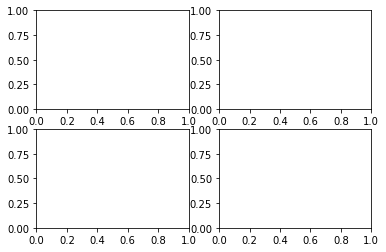

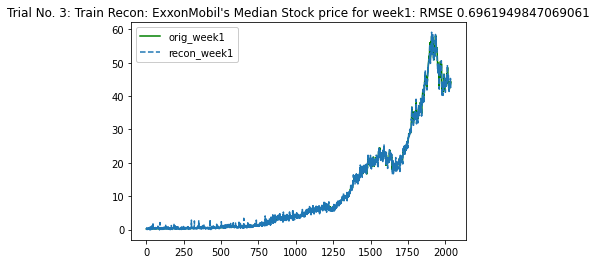

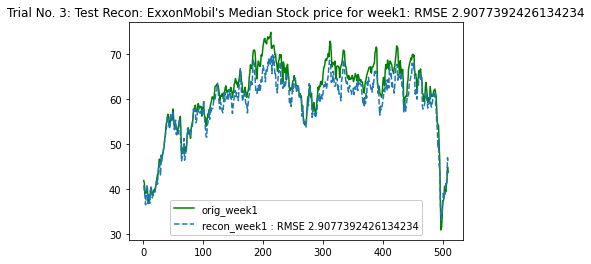

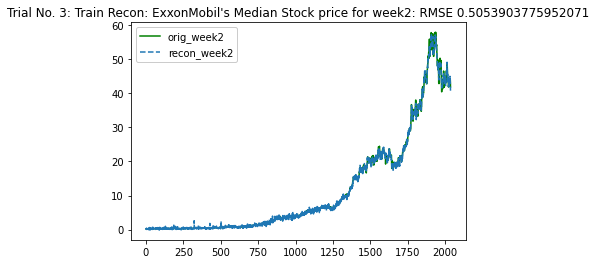

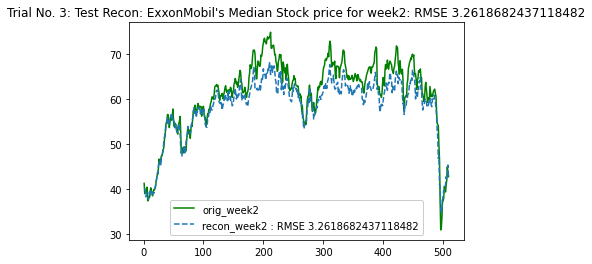

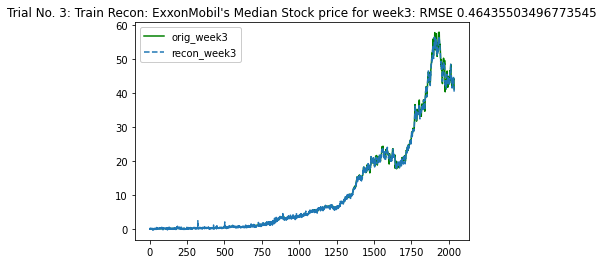

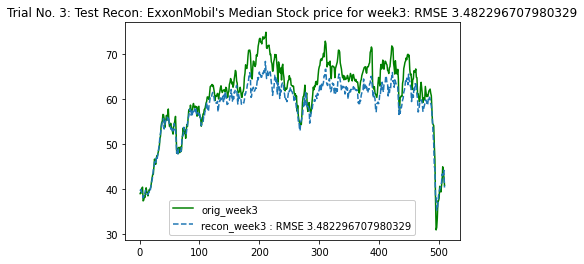

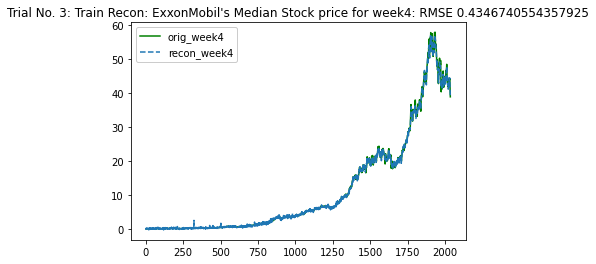

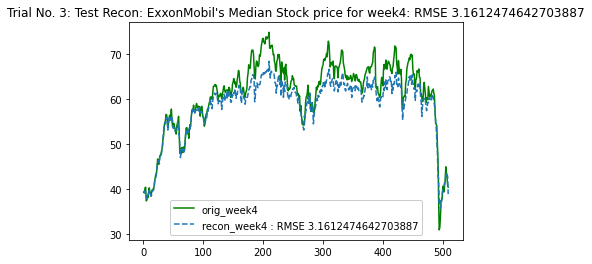

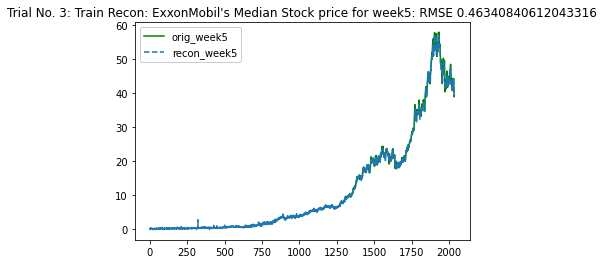

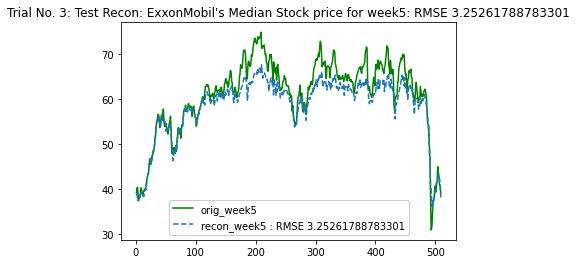

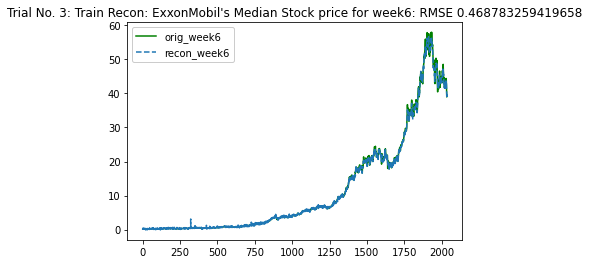

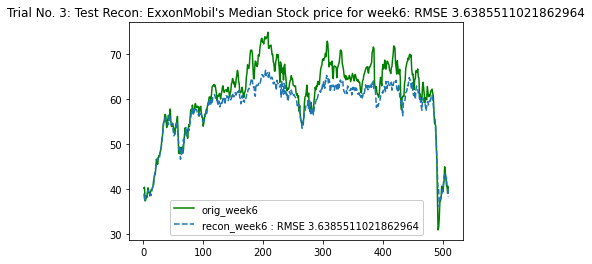

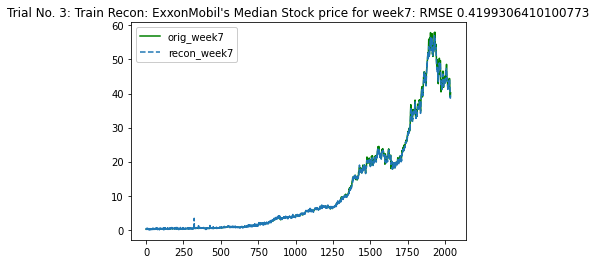

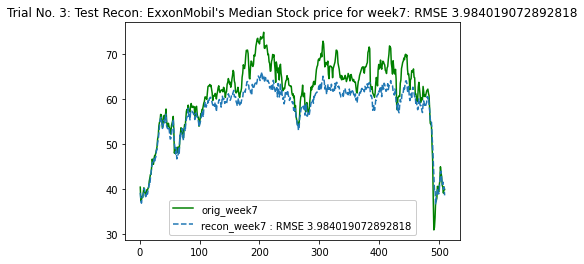

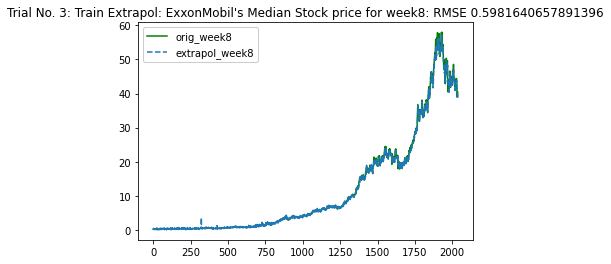

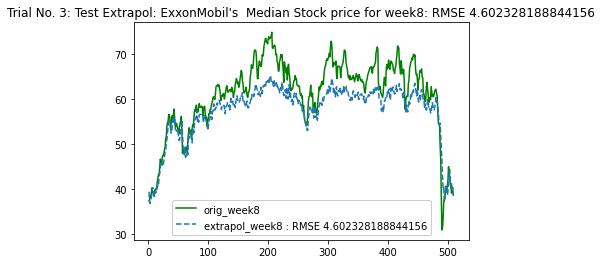

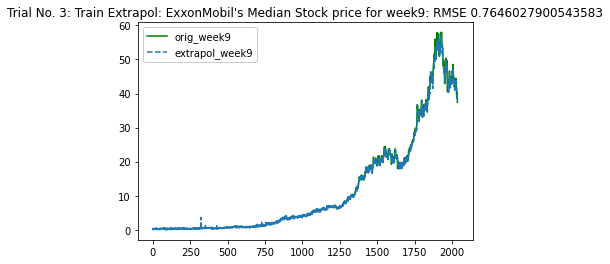

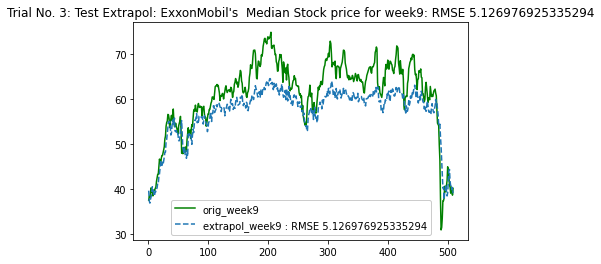

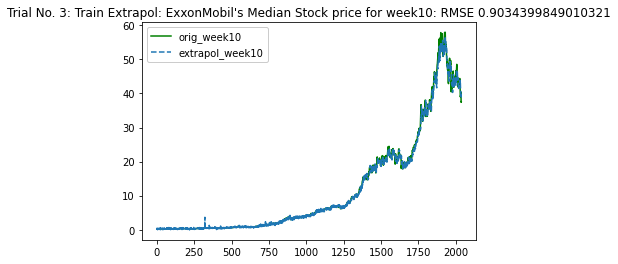

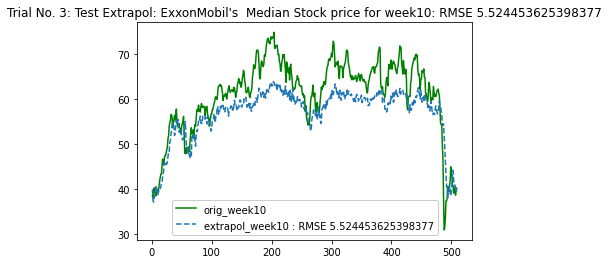

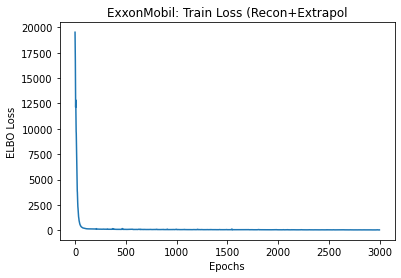

In [8]:
# Plots
fig, axes = plt.subplots(2, 2)
for i in range(1, lag+forecast+1):
    if i<=lag:
        plot_train_recon(i, train_y_recon, pred_train_recon, fig, axes)
        plot_test_recon(i, test_y_recon, pred_test_recon, fig, axes)
    elif i>lag:
        plot_train_extrapol(i, train_y_extrapol, pred_train_extrapol, fig, axes)
        plot_test_extrapol(i, test_y_extrapol, pred_test_extrapol, fig, axes)
plot_loss(loss_list)

In [9]:
# RMSE Table
recon_rmse_filepath = f"results-latentode/{tickerName}-trial{trial}-recon-rmse.csv"
extrapol_rmse_filepath = f"results-latentode/{tickerName}-trial{trial}-extrapol-rmse.csv"
recon_rmse_data, extrapol_rmse_data = rmse_table(recon_rmse_filepath, extrapol_rmse_filepath, train_y_recon, pred_train_recon, train_y_extrapol, pred_train_extrapol, test_y_recon, pred_test_recon, test_y_extrapol, pred_test_extrapol)

pd.read_csv(f"results-latentode/{tickerName}-trial{trial}-recon-rmse.csv", index_col=0)

,week,train_recon_rmse,test_recon_rmse
0,1,0.696195,2.907739
1,2,0.505390,3.261868
2,3,0.464355,3.482297
3,4,0.434674,3.161247
4,5,0.463408,3.252618
5,6,0.468783,3.638551
6,7,0.419931,3.984019


In [10]:
pd.read_csv(f"results-latentode/{tickerName}-trial{trial}-extrapol-rmse.csv", index_col=0)

,week,train_extrapol_rmse,test_extrapol_rmse
0,8,0.598164,4.602328
1,9,0.764603,5.126977
2,10,0.903440,5.524454


### Rough

In [ ]:
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd 
from pandas import concat
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
from torchdiffeq.torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dict_tickers = {
    'Apple': 'AAPL',
    'Microsoft': 'MSFT',
    'Google': 'GOOG',
    'Bitcoin': 'BTC-USD',
    'Facebook': 'FB',
    'Walmart': 'WMT',
    'Amazon': 'AMZN',
    'CVS': 'CVS',
    'Berkshire': 'BRK-B',
    'ExxonMobil': 'XOM',
    'AtandT': 'T',
    'Costco': 'COST',
    'Walgreens': 'WBA',
    'Kroger': 'KR',
    'JPMorgan': 'JPM',
    'Verizon': 'VZ',
    'FordMotor': 'F',
    'GeneralMotors': 'GM',
    'Dell': 'DELL',
    'BankOfAmerica': 'BAC',
    'Target': 'TGT',
    'GeneralElectric': 'GE',
    'JohnsonandJohnson': 'JNJ',
    'Nvidia': 'NVDA',
    'Intel': 'INTC',
}

# FileName
tickerName = 'ExxonMobil'
# Filepath
filepath = f"raw-stock-data/{tickerName}.csv"
df = pd.read_csv(filepath)
df.set_index('Date', inplace=True)
df1 = df[['Open', 'Close']].copy()
data = df1.values 
n_samples = data.shape[0]//10*10
print(n_samples)
reshape_number = n_samples*data.shape[1]//10
print(reshape_number)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

lag = 7
forecast = 3
data_orig = series_to_supervised(data, lag, forecast).values

print(data_orig.shape)
pd.DataFrame(data_orig)

12770
2554


In [ ]:
data[:n_samples].reshape((reshape_number, 10))

array([[ 0.17828774,  0.17900951,  0.17900955, ...,  0.18045305,
         0.18045325,  0.18081413],
       [ 0.18081397,  0.18153583,  0.18153592, ...,  0.17973146,
         0.17973144,  0.17792684],
       [ 0.17792687,  0.17864873,  0.17864873, ...,  0.1775659 ,
         0.17756587,  0.17648312],
       ...,
       [39.95988854, 40.25243378, 39.42965186, ..., 38.62514877,
        38.70742997, 39.74048233],
       [40.36213957, 40.08787537, 39.67648592, ..., 40.69125748,
        41.59631712, 41.1117897 ],
       [41.44739443, 41.10246658, 40.55244513, ..., 39.75071335,
        39.704109  , 39.55495071]])

In [ ]:
def stockDataTransformer(filepath):
    df = pd.read_csv(filepath)
    df.set_index('Date', inplace=True)
    df1 = df[['Open', 'Close']].copy()
    data = df1.values
    n_samples = data.shape[0]//10*10
    reshape_number = n_samples*data.shape[1]//10
    data1 = data[:n_samples].reshape((reshape_number, 10))
    return data1

# FileName
tickerName = 'ExxonMobil'
# Filepath
filepath = f"raw-stock-data/{tickerName}.csv"
# Get the data in the required format
data = stockDataTransformer(filepath)

# # Total Data Size
data_size = data.shape[0]

print(pd.DataFrame(data))

              0          1          2  ...          7          8          9
0      0.178288   0.179010   0.179010  ...   0.180453   0.180453   0.180814
1      0.180814   0.181536   0.181536  ...   0.179731   0.179731   0.177927
2      0.177927   0.178649   0.178649  ...   0.177566   0.177566   0.176483
3      0.176483   0.173957   0.173957  ...   0.167821   0.166378   0.164212
4      0.163852   0.162769   0.162769  ...   0.164573   0.164573   0.164212
...         ...        ...        ...  ...        ...        ...        ...
2549  41.166637  40.800957  40.508416  ...  38.853703  39.447934  40.819241
2550  40.362144  39.868473  39.676488  ...  40.289005  40.142736  39.813622
2551  39.959889  40.252434  39.429652  ...  38.625149  38.707430  39.740482
2552  40.362140  40.087875  39.676486  ...  40.691257  41.596317  41.111790
2553  41.447394  41.102467  40.552445  ...  39.750713  39.704109  39.554951

[2554 rows x 10 columns]


In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

lag = 7
forecast = 3
data_orig = series_to_supervised(data, lag, forecast).values

print(data_orig.shape)
pd.DataFrame(data_orig)

(2545, 100)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.178288,0.179010,0.179010,0.181897,0.181897,0.181536,0.181536,0.180453,0.180453,0.180814,0.180814,0.181536,0.181536,0.180092,0.180092,0.179371,0.179370,0.179731,0.179731,0.177927,0.177927,0.178649,0.178649,0.178649,0.178649,0.177927,0.177927,0.177566,0.177566,0.176483,0.176483,0.173957,0.173957,0.174318,0.173596,0.173235,0.173235,0.167821,0.166378,0.164212,...,0.150859,0.150137,0.146528,0.145445,0.145445,0.144723,0.146528,0.152663,0.154829,0.154829,0.154829,0.159160,0.159160,0.158438,0.158438,0.160964,0.159521,0.156272,0.156272,0.155912,0.155912,0.154468,0.154468,0.153746,0.153746,0.154468,0.154468,0.155912,0.155190,0.154468,0.154107,0.152663,0.152663,0.155551,0.156994,0.158438,0.158438,0.157716,0.157716,0.157716
1,0.180814,0.181536,0.181536,0.180092,0.180092,0.179371,0.179370,0.179731,0.179731,0.177927,0.177927,0.178649,0.178649,0.178649,0.178649,0.177927,0.177927,0.177566,0.177566,0.176483,0.176483,0.173957,0.173957,0.174318,0.173596,0.173235,0.173235,0.167821,0.166378,0.164212,0.163852,0.162769,0.162769,0.161686,0.161686,0.164934,0.164934,0.164573,0.164573,0.164212,...,0.154829,0.159160,0.159160,0.158438,0.158438,0.160964,0.159521,0.156272,0.156272,0.155912,0.155912,0.154468,0.154468,0.153746,0.153746,0.154468,0.154468,0.155912,0.155190,0.154468,0.154107,0.152663,0.152663,0.155551,0.156994,0.158438,0.158438,0.157716,0.157716,0.157716,0.157716,0.157355,0.157355,0.157355,0.157355,0.158799,0.158799,0.158799,0.158799,0.159521
2,0.177927,0.178649,0.178649,0.178649,0.178649,0.177927,0.177927,0.177566,0.177566,0.176483,0.176483,0.173957,0.173957,0.174318,0.173596,0.173235,0.173235,0.167821,0.166378,0.164212,0.163852,0.162769,0.162769,0.161686,0.161686,0.164934,0.164934,0.164573,0.164573,0.164212,0.162047,0.160242,0.160242,0.159521,0.158799,0.153746,0.153746,0.154829,0.154468,0.150859,...,0.155912,0.154468,0.154468,0.153746,0.153746,0.154468,0.154468,0.155912,0.155190,0.154468,0.154107,0.152663,0.152663,0.155551,0.156994,0.158438,0.158438,0.157716,0.157716,0.157716,0.157716,0.157355,0.157355,0.157355,0.157355,0.158799,0.158799,0.158799,0.158799,0.159521,0.159521,0.159160,0.159521,0.161686,0.162047,0.165295,0.165295,0.165656,0.165656,0.166739
3,0.176483,0.173957,0.173957,0.174318,0.173596,0.173235,0.173235,0.167821,0.166378,0.164212,0.163852,0.162769,0.162769,0.161686,0.161686,0.164934,0.164934,0.164573,0.164573,0.164212,0.162047,0.160242,0.160242,0.159521,0.158799,0.153746,0.153746,0.154829,0.154468,0.150859,0.150859,0.150137,0.146528,0.145445,0.145445,0.144723,0.146528,0.152663,0.154829,0.154829,...,0.154107,0.152663,0.152663,0.155551,0.156994,0.158438,0.158438,0.157716,0.157716,0.157716,0.157716,0.157355,0.157355,0.157355,0.157355,0.158799,0.158799,0.158799,0.158799,0.159521,0.159521,0.159160,0.159521,0.161686,0.162047,0.165295,0.165295,0.165656,0.165656,0.166739,0.166378,0.165295,0.165656,0.166017,0.166017,0.166017,0.166017,0.166739,0.166378,0.165656
4,0.163852,0.162769,0.162769,0.161686,0.161686,0.164934,0.164934,0.164573,0.164573,0.164212,0.162047,0.160242,0.160242,0.159521,0.158799,0.153746,0.153746,0.154829,0.154468,0.150859,0.150859,0.150137,0.146528,0.145445,0.145445,0.144723,0.146528,0.152663,0.154829,0.154829,0.154829,0.159160,0.159160,0.158438,0.158438,0.160964,0.159521,0.156272,0.156272,0.155912,...,0.157716,0.157355,0.157355,0.157355,0.157355,0.158799,0.158799,0.158799,0.158799,0.159521,0.159521,0.159160,0.159521,0.161686,0.162047,0.165295,0.165295,0.165656,0.165656,0.166739,0.166378,0.165295,0.165656,0.166017,0.166017,0.166017,0.166017,0.166739,0.166378,0.165656,0.165656,0.162408,0.162408,0.162408,0.162408,0.163130,0.163130,0.161686,0.161686,0.161325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
def get_median(array, axis = 1):
    # https://numpy.org/doc/stable/reference/generated/numpy.median.html
    return np.median(array, axis = axis).reshape(data_size, 1)  #, keepdims=True)

median_data = get_median(data)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# Median data for each week
print(median_data.shape)
print(pd.DataFrame(median_data, columns = ['median_stockprice_week']).head(10))
lag = 7
forecast = 3
# Convert median_data to (n_samples, 5) matrix
data_m1 = series_to_supervised(median_data, lag, forecast).values
print(data_m1.shape)
print(pd.DataFrame(data_m1, columns = [f"week i+{i}" for i in range(1, lag+forecast+1)]))


(2554, 1)
   median_stockprice_week
0                0.180634
1                0.179912
2                0.177927
3                0.173416
4                0.164032
5                0.156814
6                0.148332
7                0.158438
8                0.154468
9                0.157355
(2545, 10)
       week i+1   week i+2   week i+3  ...   week i+8   week i+9  week i+10
0      0.180634   0.179912   0.177927  ...   0.158438   0.154468   0.157355
1      0.179912   0.177927   0.173416  ...   0.154468   0.157355   0.158257
2      0.177927   0.173416   0.164032  ...   0.157355   0.158257   0.163671
3      0.173416   0.164032   0.156814  ...   0.158257   0.163671   0.166017
4      0.164032   0.156814   0.148332  ...   0.163671   0.166017   0.162408
...         ...        ...        ...  ...        ...        ...        ...
2540  39.365658  40.782675  41.893435  ...  40.439850  39.109681  40.494702
2541  40.782675  41.893435  44.951447  ...  39.109681  40.494702  39.909611
2542  41.

In [ ]:
def split_data(perc_train, perc_valid, lag, data_orig, data_m1, n_features_orig, n_features_median):
    values = data_m1
    
    sizeOfReframed = len(data_m1)
    len_train = int(perc_train*sizeOfReframed) # int(sizeOfReframed - len_test) # - len_valid)
    train_data_orig = data_orig[:len_train, :]
    # valid = values[len_train:len_valid+len_train, :]
    test_data_orig = data_orig[len_train:, :]  # [len_valid+len_train:, :]
    # n_features = n_features
    
    train_data_ml = values[:len_train, :]
    test_data_ml = values[len_train:, :] 
    # split into input and outputs
    n_obs = lag * n_features_orig
    n_obs_median = (lag+forecast) * n_features_median
    train_X, train_y = train_data_orig[:, :n_obs], train_data_ml[:, :n_obs_median]
    test_X, test_y = test_data_orig[:, :n_obs], test_data_ml[:, :n_obs_median]
    # valid_X, valid_y = valid[:, :n_obs], valid[:, -1]
    print(train_X.shape, len(train_X), train_y.shape)
    
    # reshape input to be 3D [samples, features, lag]
    train_X = train_X.reshape((train_X.shape[0], n_features_orig, lag))
    test_X = test_X.reshape((test_X.shape[0], n_features_orig, lag))
    # valid_X = valid_X.reshape((valid_X.shape[0], lag, n_features))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)  # , valid_X.shape, valid_y.shape)
    
    dataload = {
        'train_data_orig': train_data_orig,
        'test_data_orig': test_data_orig,
        'train_data_ml': train_data_ml,
        'test_data_ml': test_data_ml,
        # 'valid': valid,
        'train_X': train_X,
        'train_y': train_y,
        'test_X': test_X,
        'test_y': test_y,
        'n_features_orig': n_features_orig,
        'n_features_median': n_features_median,
        'n_obs': n_obs,
        'n_obs_median': n_obs_median,
        # 'valid_X': valid_X,
        # 'valid_y': valid_y
    }
    
    return dataload

dataload = split_data(0.8, 0, lag, data_orig, data_m1, data.shape[1], 1)


(2036, 70) 2036 (2036, 10)
(2036, 10, 7) (2036, 10) (509, 10, 7) (509, 10)


In [ ]:
train_X = torch.from_numpy(dataload['train_X']).to(device)
print(train_X.shape)  # (#training, 1, 5)

train_y = torch.from_numpy(dataload['train_y']).to(device)
print(train_y.shape)  # (#training, 5)
train_y = torch.reshape(train_y, (train_X.shape[0], 1, train_y.shape[1])).to(device)
print(train_y.shape)  # (#training, 1, 5)
test_X = torch.from_numpy(dataload['test_X']).to(device)
print(test_X.shape)  # (#testing, 1, 5)
test_y = torch.from_numpy(dataload['test_y']).to(device)
print(test_y.shape)  # (#testing, 5)
test_y = torch.reshape(test_y, (test_X.shape[0], 1, test_y.shape[1])).to(device)
print(test_y.shape)

torch.Size([2036, 10, 7])
torch.Size([2036, 10])
torch.Size([2036, 1, 10])
torch.Size([509, 10, 7])
torch.Size([509, 10])
torch.Size([509, 1, 10])


In [ ]:
# https://discuss.pytorch.org/t/rmse-loss-function/16540/3
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss
class LatentODEfunc(nn.Module):

    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x).to(device)
        out = self.elu(out).to(device)
        out = self.fc2(out).to(device)
        out = self.elu(out).to(device)
        out = self.fc3(out).to(device)
        return out


class RecognitionRNN(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=5, nhidden=25, nbatch=1):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.i2h = self.i2h.float()
        self.h2o = nn.Linear(nhidden, latent_dim * 2)
        self.h2o = self.h2o.float()

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1).to(device)
        h = torch.tanh(self.i2h(combined.float())).to(device)
        out = self.h2o(h).to(device)
        return out, h

    def initHidden(self):
        return torch.zeros(self.nbatch, self.nhidden)


class Decoder(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=5, nhidden=20):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.fc1(z).to(device)
        out = self.relu(out).to(device)
        out = self.fc2(out).to(device)
        return out


class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float().to(x.device).to(device)
    const = torch.log(const).to(device)
    return -.5 * (const + logvar + (x - mean) ** 2. / torch.exp(logvar))

def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl.to(device)

def train(loss_str, niters):
    loss_list = []
    for itr in range(1, niters + 1):
    
        optimizer.zero_grad()
        # backward in time to infer q(z_0)
        h = rec.initHidden().to(device)  # (# nbatches_train, rnn_hidden)
        for t_r in reversed(range(train_X.shape[2])):
            obs = train_X[:, :, t_r].to(device)
            # obs = torch.reshape(obs, (1, 1)).to(device)
            out, h = rec.forward(obs, h)
        qz0_mean, qz0_logvar = out[:, :latent_dim].to(device), out[:, latent_dim:].to(device)
        epsilon = torch.randn(qz0_mean.size()).to(device)
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

        # forward in time and solve ode for reconstructions
        pred_z = odeint(func, z0, t.to(device)).permute(1, 0, 2)  # [:, -1, :]
        pred_x = dec(pred_z).to(device)
        pred_x = torch.reshape(pred_x, (train_X.shape[0], lag)).to(device)

        # compute loss
        if loss_str == 'mse':
            loss = torch.nn.MSELoss()(pred_x.float(), train_X[i, :, :].float().to(device)).float()
        elif loss_str == 'elbo':
            noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
            noise_logvar = 2. * torch.log(noise_std_).to(device)
            logpx = log_normal_pdf(
                train_y[:, 0, :].to(device), pred_x, noise_logvar).sum(-1)  # .sum(-1)
            pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
            analytic_kl = normal_kl(qz0_mean, qz0_logvar,
                                    pz0_mean, pz0_logvar).sum(-1)
            loss = torch.mean(-logpx + analytic_kl, dim=0).to(device)
            # loss = torch.reshape(loss, (1, 1)).to(device)
        loss_list.append(loss)
            # loss_ = torch.mean(torch.cat([x.float() for x in loss_list])).to(device)  
        loss.backward()
        optimizer.step()
        # loss_meter.update(loss.item())
        if itr%10==0:
            print('Iter: {}, running: {:.4f}'.format(itr, loss.item()))
    return loss_list

# def train_loss(h):
#     train_loss = 0.0
#     predictions = []
#     for i in range(train_X.shape[0]):
#         for t_r in reversed(range(train_X.shape[2])):
#             obs = train_X[i, :, t_r].to(device)
#             obs = torch.reshape(obs, (1, 1)).to(device)
#             out, h = rec.forward(obs, h)
    
#         qz0_mean, qz0_logvar = out[:, :latent_dim].to(device), out[:, latent_dim:].to(device)
#         epsilon = torch.randn(qz0_mean.size()).to(device)
#         z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

#         # forward in time and solve ode for reconstructions
#         pred_z = odeint(func, z0, t.to(device)).permute(1, 0, 2)
#         pred_x = dec(pred_z).to(device)
#         rmse = RMSELoss()
#         # loss = torch.nn.MSELoss()(pred_x, train_X[i, :, :].to(device))
#         loss = rmse(pred_x, train_X[i, :, :].to(device))
#         train_loss += loss
#         predictions.append(pred_x)
    
#     # train_loss = torch.sqrt(train_loss)
#     train_pred = torch.cat([x.float() for x in predictions])
#     train_pred = torch.reshape(train_pred, (train_pred.shape[0], 1, lag))
#     with torch.no_grad():
#         print('Total Train Loss {:.6f}'.format(train_loss.item()))
#     return train_pred

def plot_train(i, train_pred):
    t_ = torch.linspace(1., train_y.shape[0], train_y.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), train_y.cpu().numpy()[:, :, i-1], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((train_y.cpu().numpy()[:, :, i-1] - train_pred.cpu().numpy()[:, :, i-1]) ** 2).mean())
        plt.plot(t_.numpy(), train_pred.cpu().numpy()[:, :, i-1], '--', label = f"pred_week{i}")
    plt.title(f"Trial No. {trial}: Train: Apple's Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Train: Apple's Median Stock price for week{i}-all.pdf", dpi = 150)
    plt.show()

# def test_loss(h, t_test):
#     # print(h.shape)
#     test_loss = 0.0
#     predictions = []
#     rmse = RMSELoss()
#     for i in range(test_X.shape[0]):
#         for t_r in reversed(range(test_y.size(3))):
#             obs = test_X[i, :, t_r].to(device)
#             obs = torch.reshape(obs, (1, 1)).to(device)
#             out, h = rec.forward(obs, h)
#         qz0_mean, qz0_logvar = out[:, :latent_dim].to(device), out[:, latent_dim:].to(device)
#         epsilon = torch.randn(qz0_mean.size()).to(device)
#         z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

#         # forward in time and solve ode for reconstructions
#         pred_z = odeint(func, z0, t_test).permute(1, 0, 2).to(device)
#         pred_x = dec(pred_z).to(device)
#         pred_x = torch.reshape(pred_x, (1, lag))
#         # print(test_pred_y.shape)
#         rmse = RMSELoss()
#         # loss = torch.nn.MSELoss()(pred_x, train_X[i, :, :].to(device))
#         loss = rmse(pred_x, test_X[i, :, :].to(device))

#         # loss = torch.nn.MSELoss()(pred_x, torch.reshape(test_X[i, :, :].to(device), (1, 5))).to(device)
#         test_loss += loss
#         predictions.append(pred_x)
    
#     # test_loss = torch.sqrt(test_loss)
#     test_pred = torch.cat([x.float() for x in predictions])
    
#     # loss = torch.nn.MSELoss()(test_pred_y[train_size-test_size:, batch_time2-2, :], label_batch_y[train_size-test_size:, batch_time2-2, :])
#     with torch.no_grad():
#         print('Total Loss {:.6f}'.format(test_loss.item()))
#     return test_pred
def plot_test(i, test_pred):
    t_ = torch.linspace(1., test_X.shape[0], test_X.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), test_y.cpu().numpy()[:, :, i-1], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((test_y.cpu().numpy()[:, :, i-1] - test_pred.cpu().numpy()[:, :, i-1]) ** 2).mean())
        plt.plot(t_.numpy(), test_pred.cpu().numpy()[:, :, i-1], '--', label = f"pred_week{i+lag} : RMSE {rmse}")
    plt.title(f"Trial No. {trial}: Test_X: Apple's Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Test_X: Apple's Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_loss(loss_list):
    plt.plot(loss_list)
    plt.title('Train Loss')
    plt.ylabel('RMSE Loss')
    plt.xlabel('Epochs')
    plt.savefig(f"plots-latentode/Trial No. {trial}: RMSE Train Loss.pdf", dpi = 150)
    plt.show()

In [ ]:
t = torch.linspace(0, lag+forecast-1, lag+forecast)
print(t.shape)

latent_dim = 4
nhidden = 20
rnn_nhidden = 25
obs_dim = data.shape[1]
out_dim = 1
noise_std = .3

## Training
# model
nbatches_train = train_X.shape[0]
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nbatches_train).to(device)
dec = Decoder(latent_dim, out_dim, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
lr = 0.001
optimizer = optim.Adam(params, lr=lr)
loss_str = 'elbo'
# all_values = True
niters = 100  # training epochs

torch.Size([10])


In [ ]:
h = rec.initHidden().to(device) # (# nbatches_train, rnn_hidden)
print(h.shape)
obs = train_X[:, :, 0].to(device)
print(obs.shape)
# obs = torch.reshape(obs, (1, 1)).to(device)
out, h = rec.forward(obs, h)

torch.Size([2036, 25])
torch.Size([2036, 10])


In [ ]:
qz0_mean, qz0_logvar = out[:, :latent_dim].to(device), out[:, latent_dim:].to(device)

epsilon = torch.randn(qz0_mean.size()).to(device)
z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

# forward in time and solve ode for reconstructions
pred_z = odeint(func, z0, t.to(device)).permute(1, 0, 2)  # [:, -1, :]
print(pred_z.shape)


torch.Size([2036, 10, 4])


In [ ]:
pred_x = dec(pred_z).to(device)
print(pred_x.shape)
pred_x = torch.reshape(pred_x, (train_X.shape[0], lag+forecast)).to(device)
print(pred_x.shape)

torch.Size([2036, 10, 1])
torch.Size([2036, 10])


In [ ]:
noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
noise_logvar = 2. * torch.log(noise_std_).to(device)
print(noise_logvar.shape)
print(train_y[:, 0, :].shape)

torch.Size([2036, 10])
torch.Size([2036, 10])


In [ ]:
logpx = log_normal_pdf(
    train_y[:, 0, :].to(device), pred_x, noise_logvar).sum(-1)  # .sum(-1)
pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
analytic_kl = normal_kl(qz0_mean, qz0_logvar,
                        pz0_mean, pz0_logvar).sum(-1)
loss = torch.mean(-logpx + analytic_kl, dim=0).to(device)
loss

tensor(19548.2856, dtype=torch.float64, grad_fn=<MeanBackward1>)

## m1m2m3m4m5m6m7m8 as input and m1m2m3m4m5m6m7m8m9m10 as output. m9m10 as output of test